# Welcome to NameWeave (MLP) - Activations, Gradients & Batch Normalization

Let's rearrange our last code from <a href="https://github.com/AvishakeAdhikary/Neural-Networks-From-Scratch/blob/main/NameWeave%20-%20Multi%20Layer%20Perceptron.ipynb">NameWeave - Multi Layer Perceptron</a> file, to make it look a little bit more tidier first.

# Installing Dependencies

In [1]:
!pip install torch
!pip install numpy
!pip install pandas
!pip install matplotlib


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Importing Libraries

In [2]:
import random
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\avhis\AppData\Local\Temp\ipykernel_13860\3082457058.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Loading Dataset


In [3]:
words = open("Datasets/Indian_Names.txt").read().splitlines()
words = [word.lower() for word in words]

In [4]:
len(words)

53982

# Building Vocabulary


In [5]:
# Remember we need our starting and ending tokens as well in these mappings,
characters = sorted(list(set(''.join(words)))) # Gives us all the characters in the english alphabet, hopefully our dataset has all of them
stoi = {s:i+1 for i,s in enumerate(characters)} # Enumerate returns the tuples of number and string, which can then be mapped to string:index
# We manually add these tokens for convenience
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()} # After we have the string:index mapping, we can easily iterate over their items to map index:string
print("Characters:", characters)
print("STOI:", stoi)
print("ITOS", itos)
# We define a common vocabulary size
vocabularySize = len(stoi)
print("Vocabulary Size:", vocabularySize)

Characters: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
STOI: {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
ITOS {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
Vocabulary Size: 27


# Building Dataset

In [7]:
# We define a Block Size based on the number of characters we feed are going to feed to predict the next one
blockSize = 3
# Will build the dataset on only the words we take as input
def buildDataset(words):
    # We define two lists, inputs & outputs, where inputs are our blocks of the block size mentioned above and outputs are the label indexes
    inputs , outputs = [], []
    # We iterate over each word
    for word in words:
        # We define the block for each iteration and fill it with 0 values -> [0, 0, 0]
        block = [0] * blockSize
        # We run another loop for each word's character, here word also needs the ending token '.'
        for character in word + '.':
            # We take out the index from our look-up table
            index = stoi[character]
            # We append the input with our block
            inputs.append(block)
            # We append the output label with out index of the character
            outputs.append([index])
            # We then take the block, crop it 1 size from the left and append the next index to it (sliding window of name)
            block = block[1:] + [index]
    # We also convert these inputs and outputs to tensors for neural network processing
    inputs = torch.tensor(inputs)
    outputs = torch.flatten(torch.tensor(outputs))
    # We return the inputs and outputs
    return inputs, outputs

# We define a manual seed to random
random.seed(69)
# We shuffle all the words, so that the model receives all kinds of data
random.shuffle(words)
# We define two number of inputs
# We take the number of examples to 80% in the first variable
numberOfInputs1 = int(0.8*len(words))
# We take the number of examples to 90% in the first variable
numberOfInputs2 = int(0.9*len(words))
# Inputs and outputs that go till 80% of the examples
trainingInputs, trainingOutputs = buildDataset(words[:numberOfInputs1])
# Inputs and outputs that start at 80% of the examples and go till 90% of the examples
validationInputs, validationOutputs = buildDataset(words[numberOfInputs1:numberOfInputs2])
# Inputs and outputs that start at 90% of the examples
testInputs, testOutputs = buildDataset(words[numberOfInputs2:])

# We can check the numbers
print("Total Examples:",len(words)) # 100%
print("Training Examples:",len(words[:numberOfInputs1])) # 80%
print("Validation Examples:",len(words[numberOfInputs1:numberOfInputs2])) # 10%
print("Test Examples:",len(words[numberOfInputs2:])) # 10%

Total Examples: 53982
Training Examples: 43185
Validation Examples: 5398
Test Examples: 5399


# Neural Network Initialization - Weights, Biases & Parameters

In [7]:
# We will define a generator to give the same result on your machine, as of my machine
generator = torch.Generator().manual_seed(6942069420)
# Embedding Matrix (Input Layer)
embeddingFeatureSpaceLength = 10 
embeddingLookUpMatrix = torch.randn((vocabularySize, embeddingFeatureSpaceLength), generator=generator)
# Hidden Layer
numberOfHiddenLayerNeurons = 200 # We increase the number of neurons here
weightsOfHiddenLayer = torch.randn((blockSize*embeddingFeatureSpaceLength), numberOfHiddenLayerNeurons, generator=generator)
biasesOfHiddenLayer = torch.randn(numberOfHiddenLayerNeurons, generator=generator)
# Output Layer / Final Layer
weightsOfFinalLayer = torch.randn(numberOfHiddenLayerNeurons, vocabularySize, generator=generator)
biasesOfFinalLayer = torch.randn(vocabularySize, generator=generator)
# Parameters
parameters = [embeddingLookUpMatrix, weightsOfHiddenLayer, biasesOfHiddenLayer, weightsOfFinalLayer, biasesOfFinalLayer]
# We set all the requires gradient to True
for parameter in parameters:
    parameter.requires_grad = True

# Neural Network - Training, Back-Propagation & Updation

In [8]:
# We want to track the losses that we use in the training
losses = []

# We define the number of epochs
epochs = 200000
for i in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=trainingInputs.shape[0], size=(32,)) # I changed it to 32 to make it look nicer in my mind
    inputBatch, outputBatch = trainingInputs[indexes], trainingOutputs[indexes]
    
    # Forward Pass (Mini-Batch)
    embedding = embeddingLookUpMatrix[inputBatch]
    concatenatedEmbedding = embedding.view(embedding.shape[0], -1) # These are all the input examples in a concatenated form
    hiddenLayerPreActivationStates = embedding.view(-1, blockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer
    hiddenLayerPostActivationStates = torch.tanh(hiddenLayerPreActivationStates) # We divided the states into two parts pre and post non-linearity
    logits = hiddenLayerPostActivationStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, trainingOutputs[indexes])
    
    # Backward Pass (Mini-Batch)
    for parameter in parameters:
        parameter.grad = None
    loss.backward()
    
    # Update Weights (Mini-Batch)
    learning_rate = 0.1 if i < 100000 else 0.01
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

    # Tracking the stats
    # We append the losses that we use per iteration
    if i % 10000 == 0: 
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item()) # We do that to squash the steep curve to a nicer graph
print("Minibatch Loss:", loss)

      0/ 200000: 19.1089
  10000/ 200000: 2.4038
  20000/ 200000: 2.5345
  30000/ 200000: 2.3764
  40000/ 200000: 2.2033
  50000/ 200000: 2.4644
  60000/ 200000: 2.7114
  70000/ 200000: 1.8577
  80000/ 200000: 2.0025
  90000/ 200000: 2.0223
 100000/ 200000: 2.4540
 110000/ 200000: 2.5580
 120000/ 200000: 1.9447
 130000/ 200000: 1.7552
 140000/ 200000: 1.9592
 150000/ 200000: 2.0105
 160000/ 200000: 1.8851
 170000/ 200000: 1.6896
 180000/ 200000: 2.0900
 190000/ 200000: 1.6866
Minibatch Loss: tensor(2.0844, grad_fn=<NllLossBackward0>)


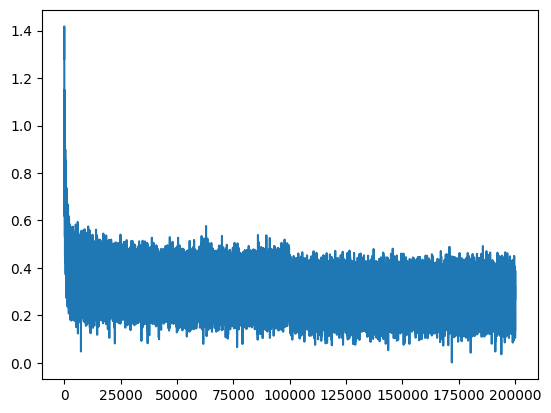

In [9]:
plt.plot(losses)

Once again, we see a steep descent for the first few iterations

Remeber how I said,\
**We tend to calculate the loss on a test-split very cautiously and very few times,** \
**Because, every single time we evaluate our test loss, the model learns something from the split..** \
**So, we basically end up overfitting the test-split as well.** \
**Therefore, we are only allowed to test the loss on test-split very less times.**

Keeping exactly that in mind, we make our next snippet...

In [10]:
# Method to split the 
@torch.no_grad() # Decorator for disabling gradient tracking throughout the function underneath
def splitLoss(split):
    input, output = {
        'Training': (trainingInputs, trainingOutputs),
        'Validation': (validationInputs, validationOutputs),
        'Testing': (testInputs, testOutputs)
    }[split]
    # Based on the split we can then index into the embedding look-up matrix using its inputs to get the embeddings
    embedding = embeddingLookUpMatrix[input]
    concatenatedEmbedding = embedding.view(embedding.shape[0], -1) # These are all the input examples in a concatenated form
    hiddenLayerStates = torch.tanh(concatenatedEmbedding @ weightsOfHiddenLayer + biasesOfHiddenLayer)
    logits = hiddenLayerStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, output)
    print(f"{split} Loss:{loss.item()}")  

# We can then call this method to calculate and print loss
splitLoss('Training')
splitLoss('Validation')

Training Loss:1.961845874786377
Validation Loss:1.9897388219833374


Here,
```python
@torch.no_grad()
```
is a *decorator* in Python, and in this context, it's used to disable gradient tracking within the decorated function. \
Gradient tracking is a feature in PyTorch that keeps track of operations for automatic differentiation (backpropagation). \
Disabling it within the function is often useful when you don't want to compute gradients, such as during *inference* or when evaluating the model's performance.

# Sampling from our model

In [11]:
# We will define a generator to give the same result on your machine, as of my machine
generator = torch.Generator().manual_seed(6942069420)

# We will define a generator to give the same result on your machine, as of my machine
numberOfWordsToSample = 20

# We iterate over the number of words we want to predict
for _ in range(numberOfWordsToSample):
    # We define a output list to append the next character and print it at the end
    output = []
    # We define the block for each iteration and fill it with 0 values -> [0, 0, 0]
    block = [0] * blockSize

    # We will now iterate over each word's characters
    while True:
        # We would create an output embedding that would be based on the block
        embedding = embeddingLookUpMatrix[torch.tensor([block])]
        # We would be doing a foward pass on the above embedding vector 
        hiddenLayerStates = torch.tanh(embedding.view(1, -1) @ weightsOfHiddenLayer + biasesOfHiddenLayer)
        logits = hiddenLayerStates @ weightsOfFinalLayer + biasesOfFinalLayer
        probabilities = F.softmax(logits, dim=1)
        # We can now sample the next character
        index = torch.multinomial(probabilities, num_samples=1, generator=generator).item()
        # We then take the block, crop it 1 size from the left and append the next index to it (sliding window of name)
        block = block[1:] + [index]
        # We then append the sampled character to the output
        output.append(index)
        # If we hit '.' end token, we will break out from the loop
        if index == 0:
            break
    # We print generated name out
    print(''.join(itos[index] for index in output))

kukrunya.
hita.
niriaiththanojan.
kahidevani.
jamini.
kan.
adwaragula.
nardraseka.
kan.
agani.
najti.
aadhinoshan.
wija.
nishan.
hebakthana.
bhajilni.
prathusony.
jaravel.
jomara.
yuven.


# Understanding Losses

### Looking into our initial Loss

This is me recording the losses I get for the very first time I run this notebook for myself.\
You may get different losses during your own runtime.

```python
      0/ 200000: 25.4462
  10000/ 200000: 2.3372
  20000/ 200000: 2.0521
  30000/ 200000: 2.4103
  40000/ 200000: 1.9892
  50000/ 200000: 2.7770
  60000/ 200000: 2.4457
  70000/ 200000: 2.1623
  80000/ 200000: 2.1746
  90000/ 200000: 1.9633
 100000/ 200000: 1.9765
 110000/ 200000: 1.9889
 120000/ 200000: 1.8822
 130000/ 200000: 2.2266
 140000/ 200000: 1.8511
 150000/ 200000: 1.9462
 160000/ 200000: 1.9257
 170000/ 200000: 2.2852
 180000/ 200000: 2.0552
 190000/ 200000: 2.0097
Minibatch Loss: tensor(1.5459, grad_fn=<NllLossBackward0>)
```

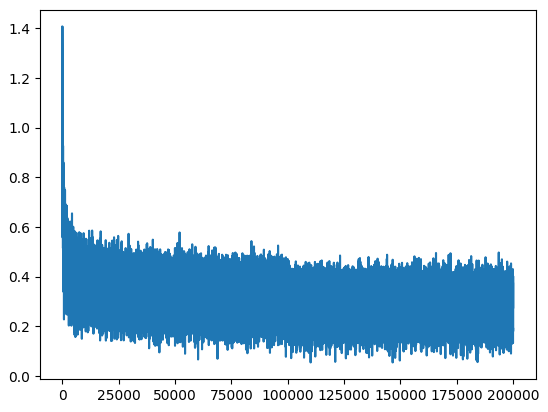

You see how the loss at the beginning is *25.4462* and then it suddenly comes down to *2.3372*?

First of all, during the training of the neural networks you always have a rough idea of **what the loss is going to be** during the **initialization of the neural network** itself.

How?\
Well it totally depends on the loss function and the problem setup.

Let's calculate what the loss in our case should we be expecting, together...

### Calculating Expected Loss

We understand that we are trying to classify the character that comes our of our neural network from our 27 characters.\
So we have no reason to believe that whatever comes out of the neural network to be more likely than the other.\
Thus, we expect that whatever comes out of our neural network is an uniform distribution, assigning all equal probabilities to all the 27 characters.


What Is the Formula for **Uniform Distribution**? \
The formula for a ***discrete uniform distribution*** is:

$$ P_x = \frac{1}{n} $$
where, $$n = \text{Number of values in the range}$$

Therefore,\
We expect loss to be roughly:
$$ P_x = \frac{1}{27} $$


And because we are doing the negetive log likelihood,\
we will have:
$$ -\log(P_x = \frac{1}{27}) $$

which is roughly:
```python
-torch.tensor(1/27.0).log()
```
```python
3.2958
```

which is much less than our original
```python
25.4462
```


**What is happening?**

Well, the neural network is currently very confident about some characters and very unconfident for some characters.\
And so it is very confidently wrong at times and that's what makes it record such high loss.

#### Let's understand this now

First let's understand how softmax works.

The softmax function is a function that turns a vector of K real values into a into a probability distribution of K real values that sum to 1.

![](https://ik.imagekit.io/botpenguin1/assets/website/Softmax_Function_07fe934386.png)

$$\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{N} e^{x_j}}$$
where $x_i$ is the $i$-th element of the input vector, and $N$ is the total number of elements in the vector.


Let's take a 4-dimensional example to understand it first

```python
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probabilities = torch.softmax(logits, dim=0)
loss = -probabilities[2].log() # Just for the sake of the example I am indexing into the 3rd element
print("Logits:", logits)
print("Probabilities:", probabilities)
print("Loss (3rd element):", loss)
```

Output we get:
```python
Logits: tensor([0., 0., 0., 0.])
Probabilities: tensor([0.2500, 0.2500, 0.2500, 0.2500])
Loss (3rd element): tensor(1.3863)
```

This happens because:
$$\text{softmax}(0.0) = \frac{e^{0.0}}{e^{0.0} + e^{0.0} + e^{0.0} + e^{0.0}}$$

Since $e^0 = 1$, this simplifies to:

$$ \text{softmax}(0.0) = \frac{1}{1 + 1 + 1 + 1} = \frac{1}{4} = 0.25 $$

We can try changing an element to a very high number say *5*,

```python
logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
probabilities = torch.softmax(logits, dim=0)
loss = -probabilities[2].log() # Just for the sake of the example I am indexing into the 3rd element
print("Logits:", logits)
print("Probabilities:", probabilities)
print("Loss (3rd element):", loss)
```

Output we get: (Very low loss)
```python
Logits: tensor([0., 0., 5., 0.])
Probabilities: tensor([0.0066, 0.0066, 0.9802, 0.0066])
Loss (3rd element): tensor(0.0200)

```

It can happen that some other logit may have this high number *(5)* and we have a normal *(0)*,

```python
logits = torch.tensor([0.0, 5.0, 0.0, 0.0])
probabilities = torch.softmax(logits, dim=0)
loss = -probabilities[2].log() # Just for the sake of the example I am indexing into the 3rd element
print("Logits:", logits)
print("Probabilities:", probabilities)
print("Loss (3rd element):", loss)
```

Output we get: (Very high loss)
```python
Logits: tensor([0., 5., 0., 0.])
Probabilities: tensor([0.0066, 0.9802, 0.0066, 0.0066])
Loss (3rd element): tensor(5.0200)
```

So the moment they start taking extreme values separate from one another,
```python
logits = torch.tensor([-3.0, 5.0, 0.0, 0.0])
probabilities = torch.softmax(logits, dim=0)
loss = -probabilities[2].log() # Just for the sake of the example I am indexing into the 3rd element
print("Logits:", logits)
print("Probabilities:", probabilities)
print("Loss (3rd element):", loss)
```
Output we get: (Very high loss)
```python
Logits: tensor([-3.,  5.,  0.,  0.])
Probabilities: tensor([3.3089e-04, 9.8638e-01, 6.6462e-03, 6.6462e-03])
Loss (3rd element): tensor(5.0137)
```

Makes sense, but want a `torch.randn()` example?

I've got you covered... (Keep in mind that whatever comes out of `torch.randn()` is of normal distribution)

Let's take a `torch.randn()` example,
```python
logits = torch.randn(4)
probabilities = torch.softmax(logits, dim=0)
loss = -probabilities[2].log() # Just for the sake of the example I am indexing into the 3rd element
print("Logits:", logits)
print("Probabilities:", probabilities)
print("Loss (3rd element):", loss)
```
Output I get: (Because the logits that come out are near 0, outputs turn out to be okay)
```python
Logits: tensor([-0.2112,  0.6164, -0.3974, -1.2911])
Probabilities: tensor([0.2243, 0.5132, 0.1862, 0.0762])
Loss (3rd element): tensor(1.6808)
```

But when we start scaling up the values,
```python
logits = torch.randn(4)  * 10
probabilities = torch.softmax(logits, dim=0)
loss = -probabilities[2].log() # Just for the sake of the example I am indexing into the 3rd element
print("Logits:", logits)
print("Probabilities:", probabilities)
print("Loss (3rd element):", loss)
```
Output we get: (I recorded 5 examples)
```python
Logits: tensor([-19.9521,  16.8229, -14.9549,  22.1436])
Probabilities: tensor([5.1990e-19, 4.8653e-03, 7.6947e-17, 9.9513e-01])
Loss (3rd element): tensor(37.1034)
,,,,,,,,
Logits: tensor([ -0.5194,   5.6846,  -1.0787, -13.2674])
Probabilities: tensor([2.0151e-03, 9.9683e-01, 1.1518e-03, 5.8599e-09])
Loss (3rd element): tensor(6.7665)
,,,,,,,,
Logits: tensor([  0.8513, -17.1741, -14.3672,   6.3023])
Probabilities: tensor([4.2736e-03, 6.3455e-11, 1.0507e-09, 9.9573e-01])
Loss (3rd element): tensor(20.6738)
,,,,,,,,
Logits: tensor([ -7.1875,  13.1279,  -9.7690, -14.5558])
Probabilities: tensor([1.5036e-09, 1.0000e+00, 1.1377e-10, 9.4873e-13])
Loss (3rd element): tensor(22.8969)
,,,,,,,,
Logits: tensor([-19.2067, -11.2704,  -0.9133,  14.4960])
Probabilities: tensor([2.3073e-15, 6.4536e-12, 2.0315e-07, 1.0000e+00])
Loss (3rd element): tensor(15.4093)
```

We see that because these get extreme values, it is very unlikely that our neural network will be guessing correctly.

If we start taking extreme scales like `100`, we can get:
```python
Logits: tensor([ -23.6667,  -79.3696, -102.5978,  178.2205])
Probabilities: tensor([0., 0., 0., 1.])
Loss (3rd element): tensor(inf)
```

Concluding the above examples,\
We want our logits to be equal or near 0.

And since we don't want to take any random arbitrary positive or negetive number, we want our logits to be near 0.

### Fixing Neural Network

#### Let's see where we go wrong in out neural network

Let's reinitialize our neural network and run the training for the very first iteration

In [12]:
# We will define a generator to give the same result on your machine, as of my machine
generator = torch.Generator().manual_seed(6942069420)
# Embedding Matrix (Input Layer)
embeddingFeatureSpaceLength = 10 
embeddingLookUpMatrix = torch.randn((vocabularySize, embeddingFeatureSpaceLength), generator=generator)
# Hidden Layer
numberOfHiddenLayerNeurons = 200 # We increase the number of neurons here
weightsOfHiddenLayer = torch.randn((blockSize*embeddingFeatureSpaceLength), numberOfHiddenLayerNeurons, generator=generator)
biasesOfHiddenLayer = torch.randn(numberOfHiddenLayerNeurons, generator=generator)
# Output Layer / Final Layer
weightsOfFinalLayer = torch.randn(numberOfHiddenLayerNeurons, vocabularySize, generator=generator)
biasesOfFinalLayer = torch.randn(vocabularySize, generator=generator)
# Parameters
parameters = [embeddingLookUpMatrix, weightsOfHiddenLayer, biasesOfHiddenLayer, weightsOfFinalLayer, biasesOfFinalLayer]
# We set all the requires gradient to True
for parameter in parameters:
    parameter.requires_grad = True

In [13]:
# We want to track the losses that we use in the training
losses = []

# We define the number of epochs
epochs = 200000
for i in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=trainingInputs.shape[0], size=(32,)) # I changed it to 32 to make it look nicer in my mind
    inputBatch, outputBatch = trainingInputs[indexes], trainingOutputs[indexes]
    
    # Forward Pass (Mini-Batch)
    embedding = embeddingLookUpMatrix[inputBatch]
    concatenatedEmbedding = embedding.view(embedding.shape[0], -1) # These are all the input examples in a concatenated form
    hiddenLayerPreActivationStates = embedding.view(-1, blockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer
    hiddenLayerPostActivationStates = torch.tanh(hiddenLayerPreActivationStates) # We divided the states into two parts pre and post non-linearity
    logits = hiddenLayerPostActivationStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, trainingOutputs[indexes])
    
    # Backward Pass (Mini-Batch)
    for parameter in parameters:
        parameter.grad = None
    loss.backward()
    
    # Update Weights (Mini-Batch)
    learning_rate = 0.1 if i < 100000 else 0.01
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

    # Tracking the stats
    # We append the losses that we use per iteration
    if i % 10000 == 0: 
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item()) # We do that to squash the steep curve to a nicer graph
    
    break # To run it only 1 time

      0/ 200000: 25.5624


Let's try to look at our logits now...

In [14]:
print(logits[0])

tensor([ -1.8624,   8.7904, -14.9665,  -4.6721,   0.8019,   5.2036,   2.0866,
         -6.5296,  -7.4507, -19.7570,  14.2915,   0.5180,  -7.9492,   4.7191,
        -12.4932,   0.8185, -11.2000,  19.9097,  -7.5701,   1.1995, -14.4465,
        -14.3768,   2.9045,   6.2003,  -2.2174,  -2.3220,  17.5950],
       grad_fn=<SelectBackward0>)


We see that they take pretty extreme values. And these logits should be very much closer to 0.

So **how can we make our logits initialize as closer to 0**?

We see that we are using:
```python
logits = hiddenLayerPostActivationStates @ weightsOfFinalLayer + biasesOfFinalLayer
```

Seems like to reduce these numbers what we can do is, we can discard the additional `bias` and scale `hiddenLayerPostActivationStates` down to a very low number...

So at initialization we can do to discard the bias is (multiplying the value with 0) and scale the hidden states to a very small number (multiplying the value with a small number),
```python
# Output Layer / Final Layer
weightsOfFinalLayer = torch.randn(numberOfHiddenLayerNeurons, vocabularySize, generator=generator) * 0.1
biasesOfFinalLayer = torch.randn(vocabularySize, generator=generator) * 0
```


In [15]:
# We will define a generator to give the same result on your machine, as of my machine
generator = torch.Generator().manual_seed(6942069420)
# Embedding Matrix (Input Layer)
embeddingFeatureSpaceLength = 10 
embeddingLookUpMatrix = torch.randn((vocabularySize, embeddingFeatureSpaceLength), generator=generator)
# Hidden Layer
numberOfHiddenLayerNeurons = 200 # We increase the number of neurons here
weightsOfHiddenLayer = torch.randn((blockSize*embeddingFeatureSpaceLength), numberOfHiddenLayerNeurons, generator=generator)
biasesOfHiddenLayer = torch.randn(numberOfHiddenLayerNeurons, generator=generator)
# Output Layer / Final Layer
weightsOfFinalLayer = torch.randn(numberOfHiddenLayerNeurons, vocabularySize, generator=generator) * 0.1
biasesOfFinalLayer = torch.randn(vocabularySize, generator=generator) * 0
# Parameters
parameters = [embeddingLookUpMatrix, weightsOfHiddenLayer, biasesOfHiddenLayer, weightsOfFinalLayer, biasesOfFinalLayer]
# We set all the requires gradient to True
for parameter in parameters:
    parameter.requires_grad = True

In [16]:
# We want to track the losses that we use in the training
losses = []

# We define the number of epochs
epochs = 200000
for i in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=trainingInputs.shape[0], size=(32,)) # I changed it to 32 to make it look nicer in my mind
    inputBatch, outputBatch = trainingInputs[indexes], trainingOutputs[indexes]
    
    # Forward Pass (Mini-Batch)
    embedding = embeddingLookUpMatrix[inputBatch]
    concatenatedEmbedding = embedding.view(embedding.shape[0], -1) # These are all the input examples in a concatenated form
    hiddenLayerPreActivationStates = embedding.view(-1, blockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer
    hiddenLayerPostActivationStates = torch.tanh(hiddenLayerPreActivationStates) # We divided the states into two parts pre and post non-linearity
    logits = hiddenLayerPostActivationStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, trainingOutputs[indexes])
    
    # Backward Pass (Mini-Batch)
    for parameter in parameters:
        parameter.grad = None
    loss.backward()
    
    # Update Weights (Mini-Batch)
    learning_rate = 0.1 if i < 100000 else 0.01
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

    # Tracking the stats
    # We append the losses that we use per iteration
    if i % 10000 == 0: 
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item()) # We do that to squash the steep curve to a nicer graph
    
    break # To run it only 1 time
print(logits[0])

      0/ 200000: 4.2238
tensor([ 0.3140, -0.4629,  0.3363, -0.4397, -3.1673, -1.2664, -2.0023,  2.1655,
         0.4829, -0.2867, -1.1459, -1.9947,  1.2862,  0.6320,  0.8221, -1.4879,
         0.0621,  0.0395,  0.3840,  0.0057,  0.3986,  0.2731,  0.0848, -0.9293,
         0.0931, -1.4960,  0.6043], grad_fn=<SelectBackward0>)


The moment we do this we see that the loss suddenly come down to something like `3.9423`\
Which is way closer to what we actually wanted (`3.2958`)

So you must be wondering what happens when we exactly set it to `0` instead of `0.1`...

In [17]:
# We will define a generator to give the same result on your machine, as of my machine
generator = torch.Generator().manual_seed(6942069420)
# Embedding Matrix (Input Layer)
embeddingFeatureSpaceLength = 10 
embeddingLookUpMatrix = torch.randn((vocabularySize, embeddingFeatureSpaceLength), generator=generator)
# Hidden Layer
numberOfHiddenLayerNeurons = 200 # We increase the number of neurons here
weightsOfHiddenLayer = torch.randn((blockSize*embeddingFeatureSpaceLength), numberOfHiddenLayerNeurons, generator=generator)
biasesOfHiddenLayer = torch.randn(numberOfHiddenLayerNeurons, generator=generator)
# Output Layer / Final Layer
weightsOfFinalLayer = torch.randn(numberOfHiddenLayerNeurons, vocabularySize, generator=generator) * 0
biasesOfFinalLayer = torch.randn(vocabularySize, generator=generator) * 0
# Parameters
parameters = [embeddingLookUpMatrix, weightsOfHiddenLayer, biasesOfHiddenLayer, weightsOfFinalLayer, biasesOfFinalLayer]
# We set all the requires gradient to True
for parameter in parameters:
    parameter.requires_grad = True

In [18]:
# We want to track the losses that we use in the training
losses = []

# We define the number of epochs
epochs = 200000
for i in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=trainingInputs.shape[0], size=(32,)) # I changed it to 32 to make it look nicer in my mind
    inputBatch, outputBatch = trainingInputs[indexes], trainingOutputs[indexes]
    
    # Forward Pass (Mini-Batch)
    embedding = embeddingLookUpMatrix[inputBatch]
    concatenatedEmbedding = embedding.view(embedding.shape[0], -1) # These are all the input examples in a concatenated form
    hiddenLayerPreActivationStates = embedding.view(-1, blockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer
    hiddenLayerPostActivationStates = torch.tanh(hiddenLayerPreActivationStates) # We divided the states into two parts pre and post non-linearity
    logits = hiddenLayerPostActivationStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, trainingOutputs[indexes])
    
    # Backward Pass (Mini-Batch)
    for parameter in parameters:
        parameter.grad = None
    loss.backward()
    
    # Update Weights (Mini-Batch)
    learning_rate = 0.1 if i < 100000 else 0.01
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

    # Tracking the stats
    # We append the losses that we use per iteration
    if i % 10000 == 0: 
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item()) # We do that to squash the steep curve to a nicer graph
    
    break # To run it only 1 time
print(logits[0])

      0/ 200000: 3.2958
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], grad_fn=<SelectBackward0>)


We get exactly what we'd expect: `3.2958`

But I don't use it as exactly `0`, because it can very easily *break the symmetry*.

For now let's just keep the value to be something as low as `0.01`.

So right now, we have some entropy and not exactly `0`.

So let's re run our optimization to see where we are...

#### Re-running Optimization

In [19]:
# We will define a generator to give the same result on your machine, as of my machine
generator = torch.Generator().manual_seed(6942069420)
# Embedding Matrix (Input Layer)
embeddingFeatureSpaceLength = 10 
embeddingLookUpMatrix = torch.randn((vocabularySize, embeddingFeatureSpaceLength), generator=generator)
# Hidden Layer
numberOfHiddenLayerNeurons = 200 # We increase the number of neurons here
weightsOfHiddenLayer = torch.randn((blockSize*embeddingFeatureSpaceLength), numberOfHiddenLayerNeurons, generator=generator)
biasesOfHiddenLayer = torch.randn(numberOfHiddenLayerNeurons, generator=generator)
# Output Layer / Final Layer
weightsOfFinalLayer = torch.randn(numberOfHiddenLayerNeurons, vocabularySize, generator=generator) * 0.01
biasesOfFinalLayer = torch.randn(vocabularySize, generator=generator) * 0
# Parameters
parameters = [embeddingLookUpMatrix, weightsOfHiddenLayer, biasesOfHiddenLayer, weightsOfFinalLayer, biasesOfFinalLayer]
# We set all the requires gradient to True
for parameter in parameters:
    parameter.requires_grad = True

In [20]:
# We want to track the losses that we use in the training
losses = []

# We define the number of epochs
epochs = 200000
for i in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=trainingInputs.shape[0], size=(32,)) # I changed it to 32 to make it look nicer in my mind
    inputBatch, outputBatch = trainingInputs[indexes], trainingOutputs[indexes]
    
    # Forward Pass (Mini-Batch)
    embedding = embeddingLookUpMatrix[inputBatch]
    concatenatedEmbedding = embedding.view(embedding.shape[0], -1) # These are all the input examples in a concatenated form
    hiddenLayerPreActivationStates = embedding.view(-1, blockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer
    hiddenLayerPostActivationStates = torch.tanh(hiddenLayerPreActivationStates) # We divided the states into two parts pre and post non-linearity
    logits = hiddenLayerPostActivationStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, trainingOutputs[indexes])
    
    # Backward Pass (Mini-Batch)
    for parameter in parameters:
        parameter.grad = None
    loss.backward()
    
    # Update Weights (Mini-Batch)
    learning_rate = 0.1 if i < 100000 else 0.01
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

    # Tracking the stats
    # We append the losses that we use per iteration
    if i % 10000 == 0: 
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item()) # We do that to squash the steep curve to a nicer graph

      0/ 200000: 3.3180
  10000/ 200000: 2.2425
  20000/ 200000: 1.8913
  30000/ 200000: 1.9384
  40000/ 200000: 2.4291
  50000/ 200000: 2.0861
  60000/ 200000: 2.2931
  70000/ 200000: 2.1123
  80000/ 200000: 1.9293
  90000/ 200000: 2.1031
 100000/ 200000: 2.1651
 110000/ 200000: 1.5266
 120000/ 200000: 1.8322
 130000/ 200000: 1.9122
 140000/ 200000: 2.1678
 150000/ 200000: 1.7529
 160000/ 200000: 1.6705
 170000/ 200000: 1.4967
 180000/ 200000: 2.1033
 190000/ 200000: 2.2284


In [21]:
# Method to split the 
@torch.no_grad() # Decorator for disabling gradient tracking throughout the function underneath
def splitLoss(split):
    input, output = {
        'Training': (trainingInputs, trainingOutputs),
        'Validation': (validationInputs, validationOutputs),
        'Testing': (testInputs, testOutputs)
    }[split]
    # Based on the split we can then index into the embedding look-up matrix using its inputs to get the embeddings
    embedding = embeddingLookUpMatrix[input]
    concatenatedEmbedding = embedding.view(embedding.shape[0], -1) # These are all the input examples in a concatenated form
    hiddenLayerStates = torch.tanh(concatenatedEmbedding @ weightsOfHiddenLayer + biasesOfHiddenLayer)
    logits = hiddenLayerStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, output)
    print(f"{split} Loss:{loss.item()}")  

# We can then call this method to calculate and print loss
splitLoss('Training')
splitLoss('Validation')

Training Loss:1.904806137084961
Validation Loss:1.9343503713607788


We see that our losses have scaled down pretty nicely and we are getting what we actually expect to see...

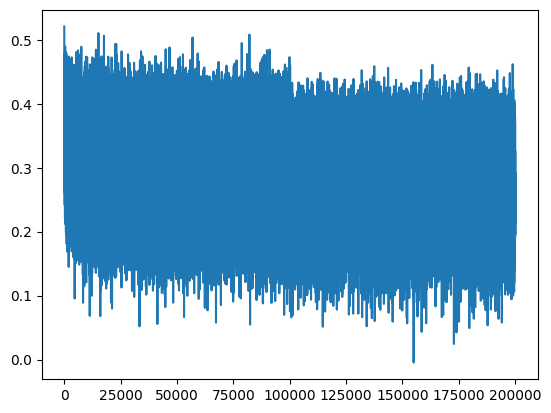

In [22]:
plt.plot(losses)

We also see that our plot of the losses now don't have the steep descent appearance.\
That is because what our optimization is *squashing* the logits down and then rearranging the logits.\
So if we took away the part of *squashing* the logits down, then we don't get these easy gains, we get the hard gains for the very first iterations...

So good things are coming up now:
1. Loss is what we expect it to be
2. Loss is coming down

```python
Original Loss: 2.0097
Loss after optimization: 1.8055
```

Why is the loss coming down you ask?

That is because, we are taking the easy part of *squashing the logits down* from the neural network, so we are **utilizing more time on optimizing** than utilizing that time in *squashing* the logits down.


#### Looking At The Second Problem

Now even though the neural network looks good in the level of loss and we are getting something that we would expect,\
There is still a very deep problem that is lurking within the network.

And the problem is with the hidden layer's post activation states.

Let's look at its states first (`hiddenLayerPostActivationStates`)

It looks something like:
```python
tensor([[ 0.6776, -1.0000,  0.9996,  ..., -1.0000,  1.0000,  1.0000],
        [-1.0000, -0.9959,  0.0871,  ..., -1.0000,  0.9988, -0.9996],
        [-0.9349, -0.9996, -0.9999,  ..., -0.9999,  0.9956, -0.5252],
        ...,
        [ 0.9995, -0.9997, -0.9941,  ..., -0.9999,  1.0000, -1.0000],
        [ 0.9955, -1.0000, -0.6141,  ..., -0.9530,  1.0000, -0.9932],
        [-0.1372, -1.0000,  0.4430,  ..., -0.1238,  1.0000,  0.6016]],
       grad_fn=<TanhBackward0>)
```

Now, we remember tanh() to be a non-linearity that acts as a *squashing* function that squashes the value between -1 and 1 smoothly.
So maybe we should be looking at the histogram of them first to understand what are they looking like...

(array([2088.,  162.,  128.,  104.,   64.,   52.,   46.,   51.,   45.,
          54.,   33.,   34.,   35.,   39.,   37.,   28.,   37.,   21.,
          29.,   20.,   17.,   22.,   17.,   39.,   21.,   30.,   28.,
          20.,   18.,   27.,   36.,   17.,   24.,   29.,   36.,   28.,
          31.,   28.,   33.,   37.,   40.,   30.,   43.,   49.,   58.,
          63.,   78.,  110.,  190., 2094.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

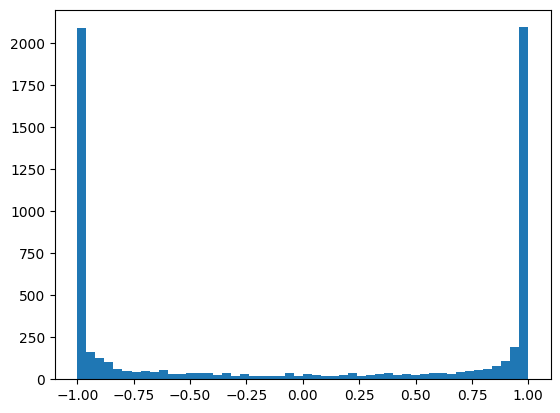

In [23]:
# We take the hiddenLayerPostActivationStates and strech them out to a large vector of a single row
# We then take the row and make a python list and put that list into the histogram method of pyplot
plt.hist(hiddenLayerPostActivationStates.view(-1).tolist(), bins=50)

We see that most of the values of that this tanh() takes on is the value lying mostly in either -1 or 1, thus, the tanh() is very very active.

And we can also see why that is...

If we try to also see the `hiddenLayerPreActivationStates` histogram...

(array([  1.,   0.,   3.,   1.,   8.,   0.,   8.,   4.,  21.,  30.,  34.,
         46.,  62.,  62., 111., 120., 157., 172., 212., 240., 286., 285.,
        303., 377., 429., 415., 384., 354., 343., 356., 286., 244., 197.,
        176., 144., 136., 106.,  87.,  62.,  43.,  28.,  30.,  13.,   7.,
          6.,   4.,   4.,   0.,   1.,   2.]),
 array([-17.39014435, -16.71161499, -16.03308563, -15.35455627,
        -14.67602692, -13.99749756, -13.3189682 , -12.64043884,
        -11.96190948, -11.28338013, -10.60485077,  -9.92632141,
         -9.24779205,  -8.5692627 ,  -7.89073334,  -7.21220398,
         -6.53367462,  -5.85514526,  -5.17661591,  -4.49808655,
         -3.81955719,  -3.14102783,  -2.46249847,  -1.78396912,
         -1.10543976,  -0.4269104 ,   0.25161896,   0.93014832,
          1.60867767,   2.28720703,   2.96573639,   3.64426575,
          4.3227951 ,   5.00132446,   5.67985382,   6.35838318,
          7.03691254,   7.71544189,   8.39397125,   9.07250061,
          9.751029

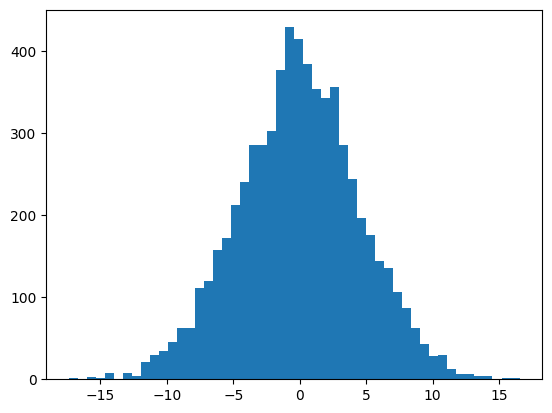

In [24]:
plt.hist(hiddenLayerPreActivationStates.view(-1).tolist(), bins=50)

We see that the values that the `hiddenLayerPreActivationStates` take on is very broad.\
They take on values roughly between -15 and 15.

And that seems to be the reason for `hiddenLayerPreActivationStates`'s activations to *squash* these values into values between -1 and 1.

Now if you're presumingly new to neural networks then this might not seem like an issue to you...\
But if know the *dark-arts* of training a neural network, and you saw this, you might be currently sweating right now...

![Sweating Catoon](https://i.pinimg.com/originals/79/8e/32/798e3279a3ac825d2bfa5573af172bc4.gif)

Let me pull up our first original Notebook <a href="https://github.com/AvishakeAdhikary/Neural-Networks-From-Scratch/blob/main/Neural%20Network%20with%20Derivatives.ipynb">Neural Network with Derivatives</a> and look at the tanh() now...

```python
def tanh(self):
    x = self.data
    exp_2x = self.exp(2*x)
    t = (exp_2x - 1) / (exp_2x + 1)
    out = Value(t.data, (self, ), 'tanh')

    def _backward():
        self.grad += (1 - t.data**2) * out.grad
    out._backward = _backward

    return out
```

We see that the **input of a tanh is** `x` and the **output of a tanh() is** `t`, and `t` is between -1 and 1 as an output.

And how do we backpropagate through tanh()...\
We take `out.grad` and we take `(1 - t.data**2)` which is the local gradient of the value...

So what happens when the values are very close to `-1` or `1`?

| If t = 1                           | If t = -1                                        | If t = 0                           |
|------------------------------------|--------------------------------------------------|------------------------------------|
| (1 - t.data**2) * out.grad         | (1 - t.data**2) * out.grad                       | (1 - t.data**2) * out.grad         |
| (1 - 1) * out.grad; since 1^2 is 1 | (1 - 1) * out.grad; since (−1)^2 = (−1)×(−1) = 1 | (1 - 0) * out.grad; since 0^2 is 0 |
| 0 * out.grad                       | 0 * out.grad                                     | 1 * out.grad                       |
| 0                                  | 0                                                | out.grad                           |

Let's consider this:
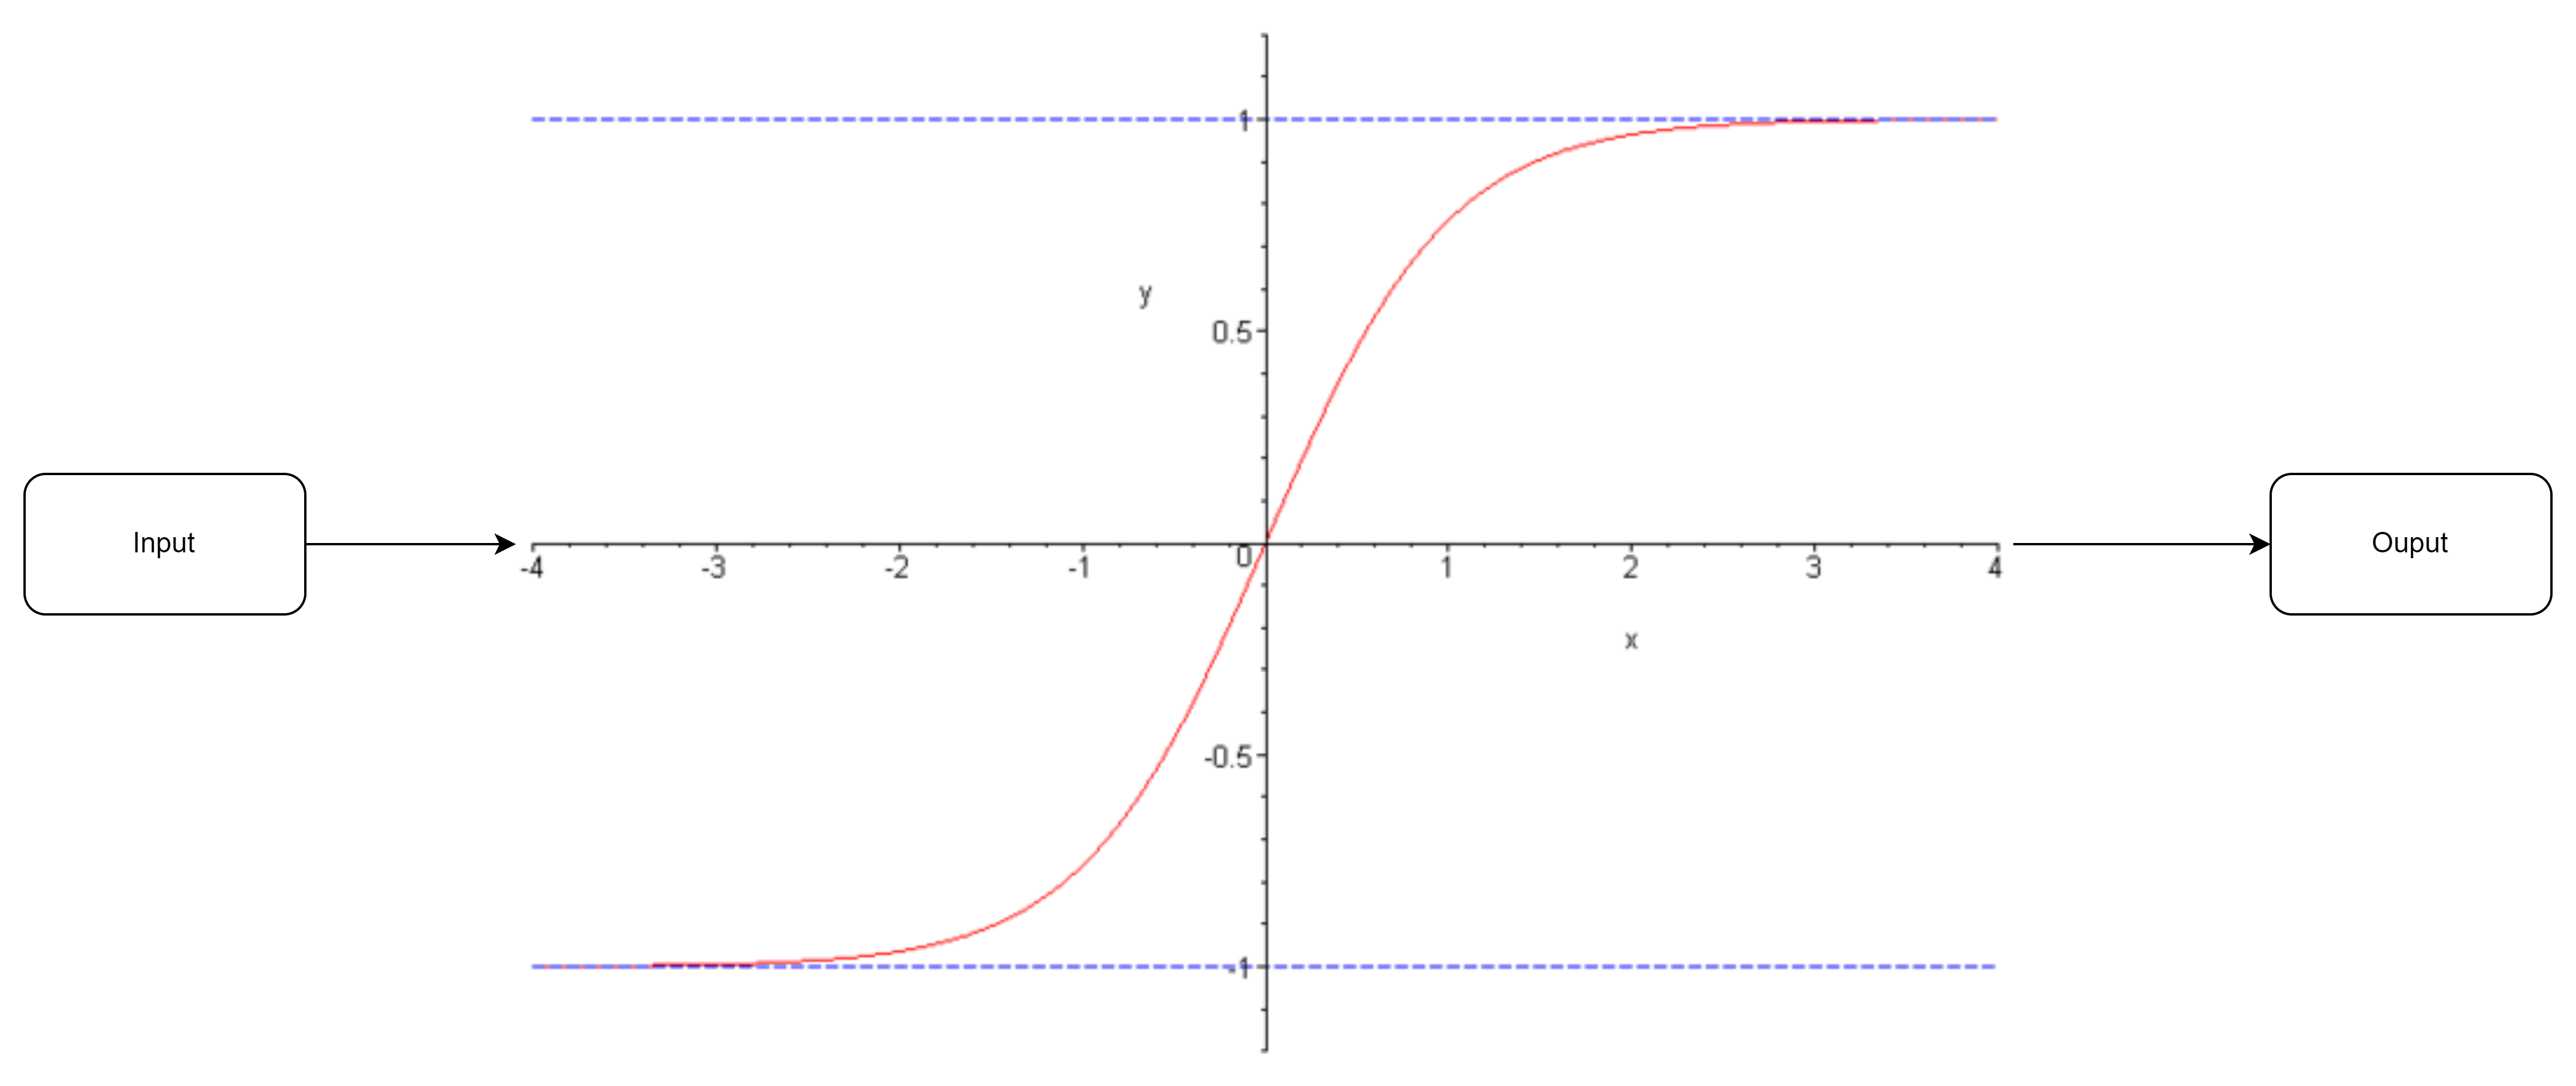

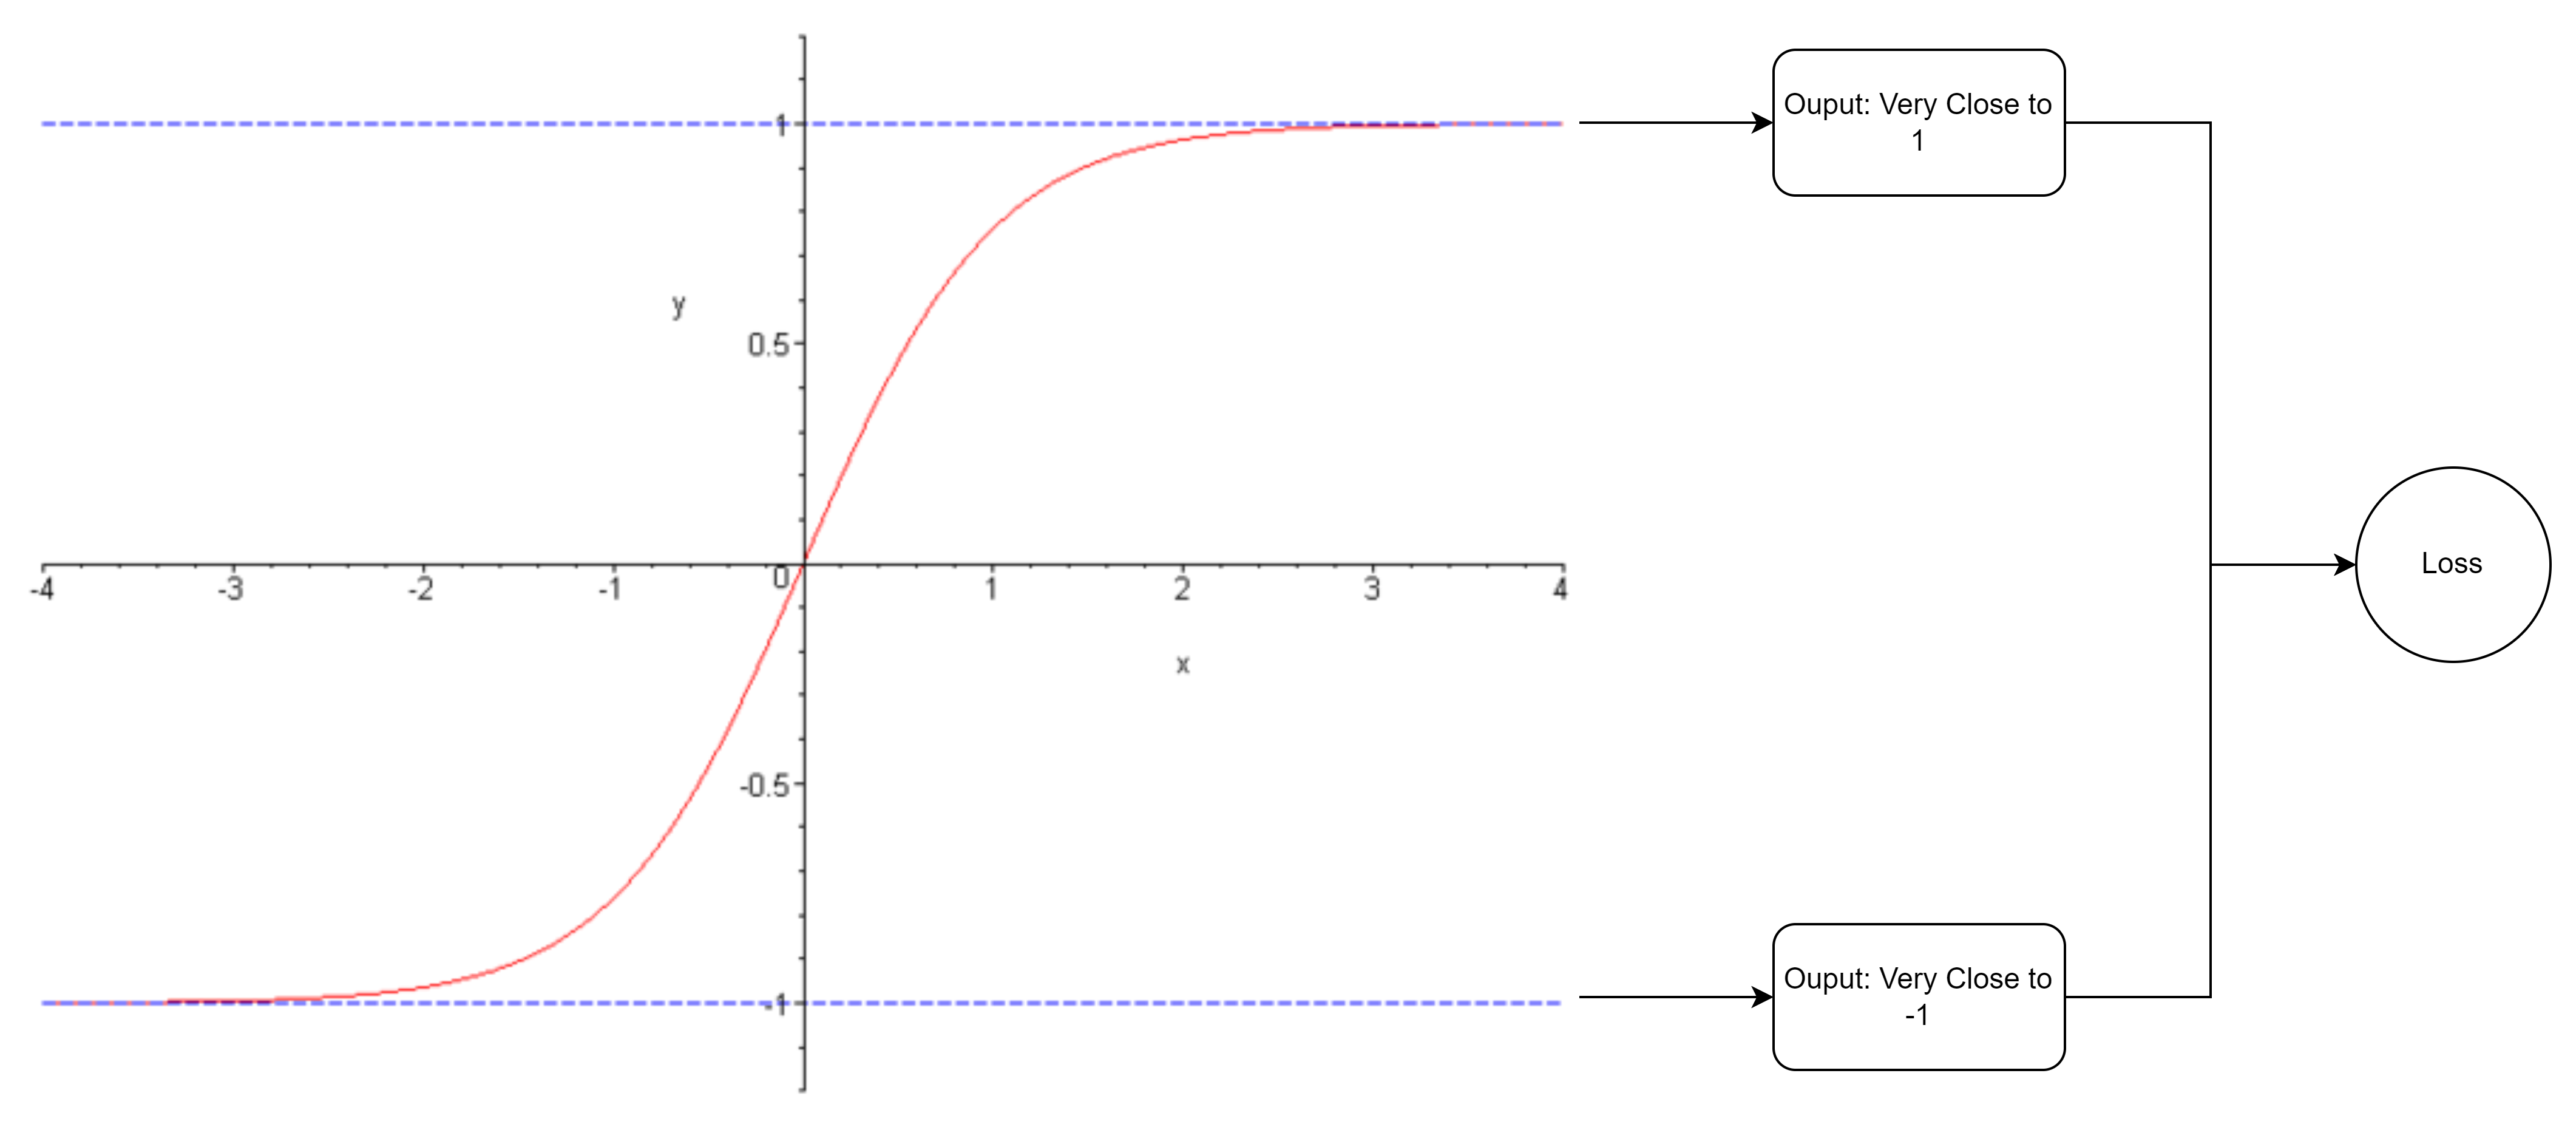
So if the output of a tanh() is very close to 1 its in the flat region of 1\
And also if the output of a tanh() is very close to -1 its in the flat region of -1

So, changing the inputs of the tanh() won't impact loss.

So, intuitively we can change the inputs of the tanh() however we want but it won't be impacting the loss and resulting the gradient to be 0 (in other words it vanishes).\
So changing the weights and the biases that come along with it, changing them won't create any impact on the loss.

Also if the of a tanh() is exactly 0, then the gradient is just passed through, meaning that the tanh() becomes **inactive**.\
But the more you're in the flat tails, the more the gradient is *squashed*, or destroyed.

So if we now try to look at our post activation states, of how often are they on the flat region...

We can try to check it with some threshold value say `0.99`.\
Meaning that any state greater than the threshold is considered in the flat region...

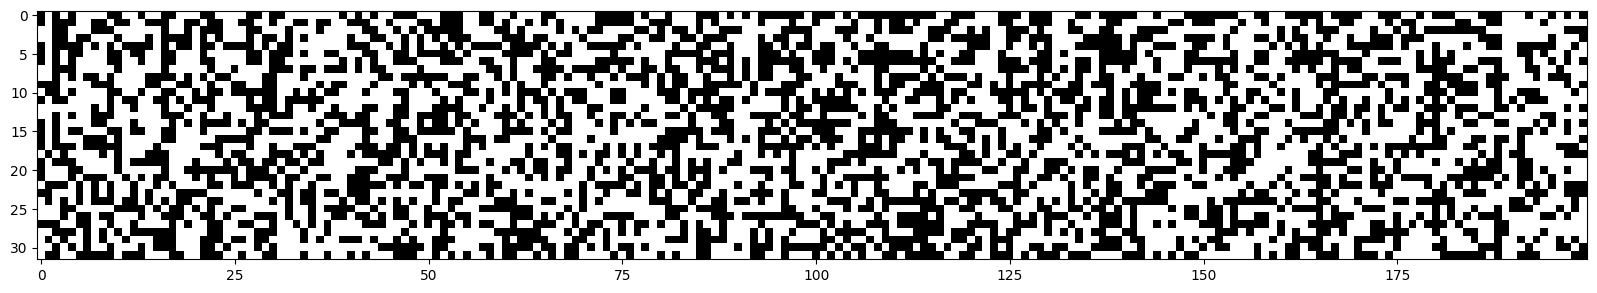

In [25]:
plt.figure(figsize=(20,10))
plt.imshow(hiddenLayerPostActivationStates.abs() > 0.99, cmap='gray', interpolation='nearest')

So what we have here is a boolean tensor.

Saying :
| Boolean | Color |
|---------|-------|
| True    | White |
| False   | Black |

And what we have here is [32, 200] or 32 input examples with 200 hidden neurons.

And we see that a lot of this is white. So this also tells us that these tanh() neurons were very very active, and thus, in all these white cases, the backward gradient will simply get destroyed.

Now if we would have been in a case where an entire column is white, we would be in a lot of trouble.\
Because if the entire column would have been white, then it would have been the case of a **dead-neuron**.\
Also meaning that, that neuron would never learn.
Thankfully we see that we are not in that case here.

This dead neurons is not just the case for tanh() but a lot of non-linearities that follow the flat tails in their regions...
![activationfunctions](https://miro.medium.com/v2/resize:fit:1200/1*ZafDv3VUm60Eh10OeJu1vw.png)

This can happen during the initialization as well as during training of the neural network.

So if during initialization the weights and biases create extreme the gradients simply get knocked out.\
But also during training if suppose we have a high learning rate, these get knocked out off the data-manifold.\
Once that is done, these neurons never activates during any training examples.

So because `hiddenLayerPreActivationStates` are very broad, when they go into the non-linearity the `hiddenLayerPostActivationStates` become very saturated. And its not something that we want because this means that these neurons update less frequently than the others.

So how do we fix this?

We see that in our forward pass,
```python
# Forward Pass (Mini-Batch)
embedding = embeddingLookUpMatrix[inputBatch]
concatenatedEmbedding = embedding.view(embedding.shape[0], -1)
hiddenLayerPreActivationStates = concatenatedEmbedding @ weightsOfHiddenLayer + biasesOfHiddenLayer
hiddenLayerPostActivationStates = torch.tanh(hiddenLayerPreActivationStates)
```
in the `hiddenLayerPreActivationStates`, the `concatenatedEmbedding` comes from `embeddingLookUpMatrix` which are uniform gaussian,\
but the `weightsOfHiddenLayer` and `biasesOfHiddenLayer` is manipulating this `concatenatedEmbedding` making our `hiddenLayerPreActivationStates` to be too far off from 0.

So again, we want these `hiddenLayerPreActivationStates` to be closer to 0. Which is very similar to what we did to 0.

So we can change the `weightsOfHiddenLayer` and `biasesOfHiddenLayer` during initialization:
```python
# Hidden Layer
numberOfHiddenLayerNeurons = 200 # We increase the number of neurons here
weightsOfHiddenLayer = torch.randn((blockSize*embeddingFeatureSpaceLength), numberOfHiddenLayerNeurons, generator=generator) * 0.1
biasesOfHiddenLayer = torch.randn(numberOfHiddenLayerNeurons, generator=generator) * 0.01
# Output Layer / Final Layer
weightsOfFinalLayer = torch.randn(numberOfHiddenLayerNeurons, vocabularySize, generator=generator) * 0.01
biasesOfFinalLayer = torch.randn(vocabularySize, generator=generator) * 0
```

Notice how I did not set the biases to 0?

That's because I want a little bit of entropy with my training and I have found that this helps the training.

### Reinitializing neural network and running optimization

In [26]:
# We will define a generator to give the same result on your machine, as of my machine
generator = torch.Generator().manual_seed(6942069420)
# Embedding Matrix (Input Layer)
embeddingFeatureSpaceLength = 10 
embeddingLookUpMatrix = torch.randn((vocabularySize, embeddingFeatureSpaceLength), generator=generator)
# Hidden Layer
numberOfHiddenLayerNeurons = 200 # We increase the number of neurons here
weightsOfHiddenLayer = torch.randn((blockSize*embeddingFeatureSpaceLength), numberOfHiddenLayerNeurons, generator=generator) * 0.01
biasesOfHiddenLayer = torch.randn(numberOfHiddenLayerNeurons, generator=generator) * 0.01
# Output Layer / Final Layer
weightsOfFinalLayer = torch.randn(numberOfHiddenLayerNeurons, vocabularySize, generator=generator) * 0.01
biasesOfFinalLayer = torch.randn(vocabularySize, generator=generator) * 0
# Parameters
parameters = [embeddingLookUpMatrix, weightsOfHiddenLayer, biasesOfHiddenLayer, weightsOfFinalLayer, biasesOfFinalLayer]
# We set all the requires gradient to True
for parameter in parameters:
    parameter.requires_grad = True

In [27]:
# We want to track the losses that we use in the training
losses = []

# We define the number of epochs
epochs = 200000
for i in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=trainingInputs.shape[0], size=(32,)) # I changed it to 32 to make it look nicer in my mind
    inputBatch, outputBatch = trainingInputs[indexes], trainingOutputs[indexes]
    
    # Forward Pass (Mini-Batch)
    embedding = embeddingLookUpMatrix[inputBatch]
    concatenatedEmbedding = embedding.view(embedding.shape[0], -1) # These are all the input examples in a concatenated form
    hiddenLayerPreActivationStates = embedding.view(-1, blockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer
    hiddenLayerPostActivationStates = torch.tanh(hiddenLayerPreActivationStates) # We divided the states into two parts pre and post non-linearity
    logits = hiddenLayerPostActivationStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, trainingOutputs[indexes])
    
    # Backward Pass (Mini-Batch)
    for parameter in parameters:
        parameter.grad = None
    loss.backward()
    
    # Update Weights (Mini-Batch)
    learning_rate = 0.1 if i < 100000 else 0.01
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

    # Tracking the stats
    # We append the losses that we use per iteration
    if i % 10000 == 0: 
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item()) # We do that to squash the steep curve to a nicer graph

      0/ 200000: 3.2964
  10000/ 200000: 2.0939
  20000/ 200000: 1.6733
  30000/ 200000: 2.5146
  40000/ 200000: 2.2274
  50000/ 200000: 1.9131
  60000/ 200000: 2.1762
  70000/ 200000: 1.8231
  80000/ 200000: 1.7015
  90000/ 200000: 2.2105
 100000/ 200000: 2.0795
 110000/ 200000: 2.1813
 120000/ 200000: 1.6440
 130000/ 200000: 1.8484
 140000/ 200000: 2.0949
 150000/ 200000: 1.9890
 160000/ 200000: 1.8960
 170000/ 200000: 2.1417
 180000/ 200000: 1.9350
 190000/ 200000: 2.0580


Now if we try to look at the plot of `hiddenLayerPostActivationStates` and plot of `hiddenLayerPreActivationStates` we get

(array([419.,  72.,  76.,  32.,  72.,  40.,  32.,  36.,  27.,  32.,  30.,
         23.,  38.,  14.,  28.,  25.,  25.,  33.,  61.,  97., 104., 208.,
        298., 459., 852., 849., 459., 285., 216., 118.,  61.,  59.,  56.,
         31.,  25.,  20.,  21.,  20.,  29.,  25.,  25.,  43.,  36.,  47.,
         56.,  56.,  76.,  53.,  95., 506.]),
 array([-1.00000000e+00, -9.60000002e-01, -9.20000005e-01, -8.80000007e-01,
        -8.40000010e-01, -8.00000012e-01, -7.60000014e-01, -7.20000017e-01,
        -6.80000019e-01, -6.40000021e-01, -6.00000024e-01, -5.60000026e-01,
        -5.20000029e-01, -4.80000031e-01, -4.40000033e-01, -4.00000036e-01,
        -3.60000038e-01, -3.20000041e-01, -2.80000043e-01, -2.40000045e-01,
        -2.00000048e-01, -1.60000050e-01, -1.20000052e-01, -8.00000548e-02,
        -4.00000572e-02, -5.96046448e-08,  3.99999380e-02,  7.99999356e-02,
         1.19999933e-01,  1.59999931e-01,  1.99999928e-01,  2.39999926e-01,
         2.79999924e-01,  3.19999921e-01,  3.59999

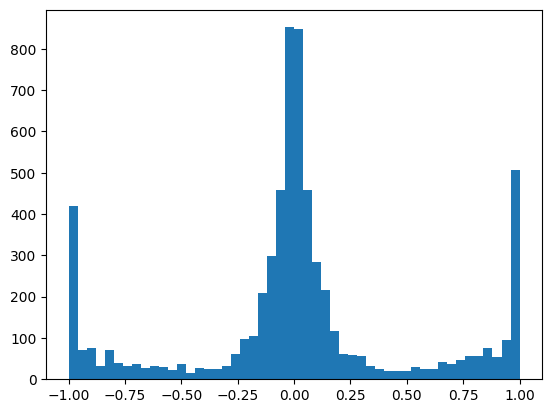

In [28]:
plt.hist(hiddenLayerPostActivationStates.view(-1).tolist(), bins=50)

(array([2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 2.000e+00, 2.000e+00, 3.000e+00, 9.000e+00, 9.000e+00,
        1.400e+01, 1.800e+01, 1.700e+01, 1.900e+01, 3.000e+01, 4.800e+01,
        4.100e+01, 6.300e+01, 6.000e+01, 7.100e+01, 6.700e+01, 1.120e+02,
        1.610e+02, 1.810e+02, 4.360e+02, 3.728e+03, 2.630e+02, 1.830e+02,
        1.960e+02, 1.020e+02, 9.200e+01, 8.400e+01, 6.400e+01, 5.900e+01,
        5.400e+01, 3.100e+01, 4.900e+01, 3.400e+01, 1.700e+01, 2.000e+01,
        1.700e+01, 8.000e+00, 6.000e+00, 8.000e+00, 4.000e+00, 6.000e+00,
        2.000e+00, 5.000e+00]),
 array([-10.18375587,  -9.81208385,  -9.44041183,  -9.06873981,
         -8.69706779,  -8.32539577,  -7.95372375,  -7.58205173,
         -7.21037971,  -6.8387077 ,  -6.46703568,  -6.09536366,
         -5.72369164,  -5.35201962,  -4.9803476 ,  -4.60867558,
         -4.23700356,  -3.86533154,  -3.49365952,  -3.1219875 ,
         -2.75031548,  -2.37864346,  -2.00697144,  -1.63

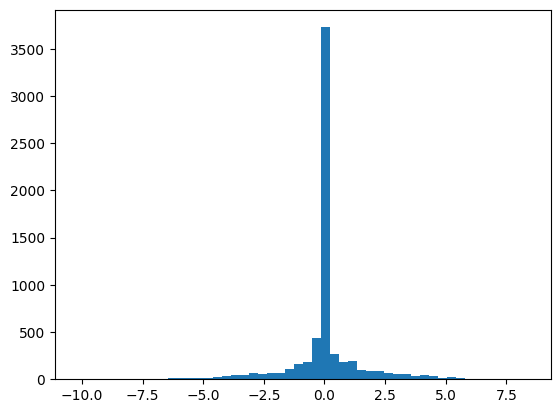

In [29]:
plt.hist(hiddenLayerPreActivationStates.view(-1).tolist(), bins=50)

So we see much better histograms of the pre and post activation states and that's because our values are not taking on extreme values.

And thus we also expect the activations to see much much less.

Let's visualize them now...

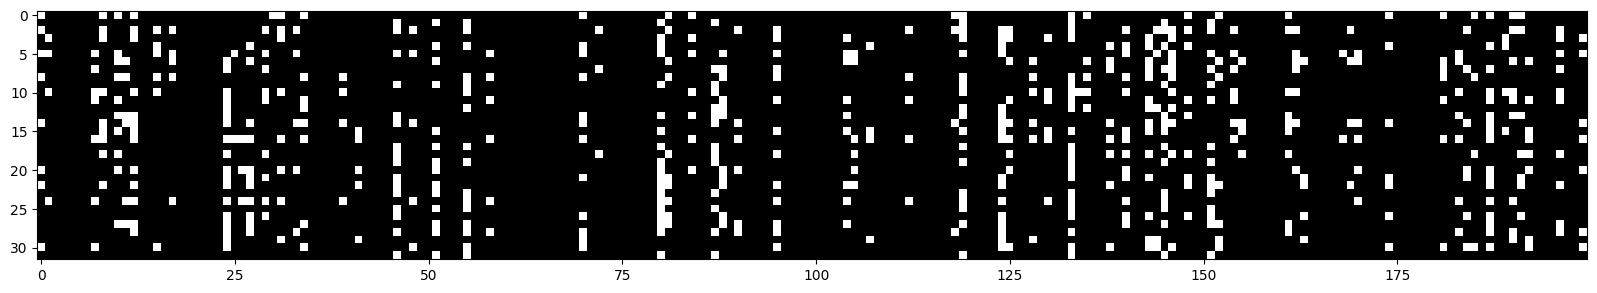

In [30]:
plt.figure(figsize=(20,10))
plt.imshow(hiddenLayerPostActivationStates.abs() > 0.99, cmap='gray', interpolation='nearest')

Note: Even if the above visualization comes out to be completely black that's fine too, but I like to have a little bit of entropy with the data.

Once again, keeping track of the loss...

We have:

In [31]:
# Method to split the 
@torch.no_grad() # Decorator for disabling gradient tracking throughout the function underneath
def splitLoss(split):
    input, output = {
        'Training': (trainingInputs, trainingOutputs),
        'Validation': (validationInputs, validationOutputs),
        'Testing': (testInputs, testOutputs)
    }[split]
    # Based on the split we can then index into the embedding look-up matrix using its inputs to get the embeddings
    embedding = embeddingLookUpMatrix[input]
    concatenatedEmbedding = embedding.view(embedding.shape[0], -1) # These are all the input examples in a concatenated form
    hiddenLayerStates = torch.tanh(concatenatedEmbedding @ weightsOfHiddenLayer + biasesOfHiddenLayer)
    logits = hiddenLayerStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, output)
    print(f"{split} Loss:{loss.item()}")  

# We can then call this method to calculate and print loss
splitLoss('Training')
splitLoss('Validation')

Training Loss:1.9219505786895752
Validation Loss:1.9380011558532715


#### Loss Logs

Original loss:
```python
Training Loss:2.009695161819458
Validation Loss:2.0099663919448853
```

After fixing confident `softmax()` activations:
```python
Training Loss:1.945695161819458
Validation Loss:1.9705663919448853
``````

After fixing hidden `tanh()` activations:
```python
Training Loss:1.9219505786895752
Validation Loss:1.9380011558532715853
```

Keep in mind that the neural network is not doing any productive training at the moment because the neural network is setting all the gradients to 0 and its just learning the simple things at in
italization.

We are just trying to understand the problems at initialization and its impact on the loss by learning the internals of the activations and gradients.

Right now, you might be wondering, what are these magic numbers and how do we set them correctly?

Well, as by now you also might've gussed it that nobody sets them by hand now and that brings me to introduce you to the relatively principled ways of setting the *normalization scales*....

Let's first take an example...

#### Understanding Magic Numbers During Initialization

Inputs -> Mean: tensor(-0.0161) Std: tensor(0.9945)
Outputs -> Mean: tensor(0.0086) Std: tensor(3.1724)


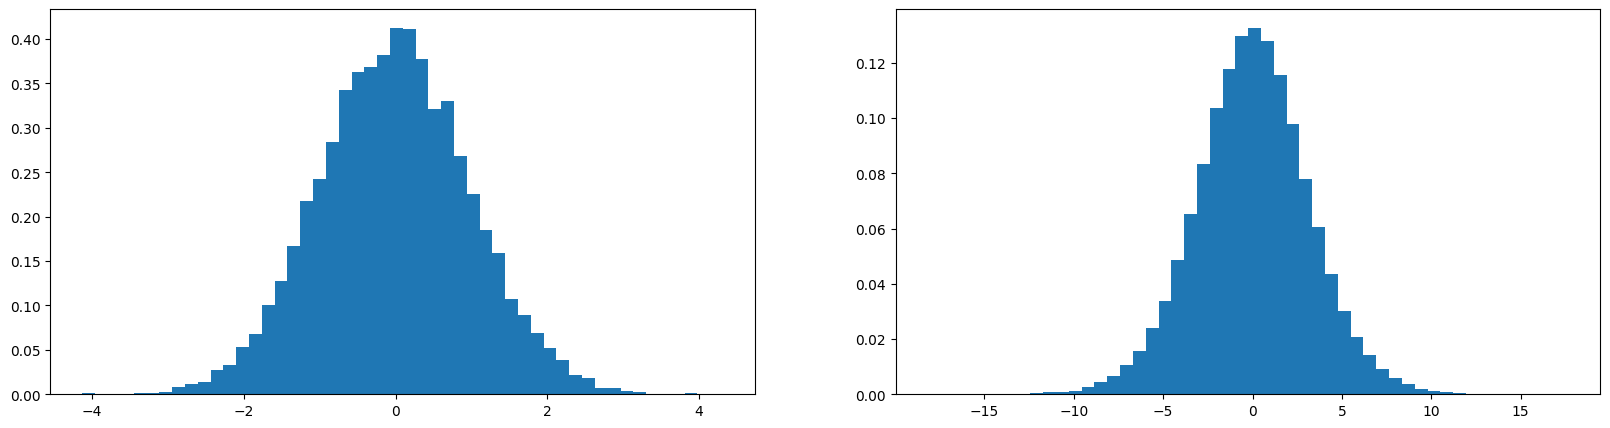

In [3]:
# This is just an example

inputs = torch.randn(1000, 10) # 1000 inputs of 10 dimensions drawn from a gaussian
weights = torch.randn(10, 200) # Also drawn from a gaussian and they look at 10 inputs and have 200 neurons within the layer

outputs = inputs @ weights

print("Inputs ->", "Mean:", inputs.mean(), "Std:", inputs.std())
print("Outputs ->", "Mean:", outputs.mean(), "Std:", outputs.std())

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(inputs.view(-1).tolist(), bins=50, density=True); # Visualizing inputs
plt.subplot(122)
plt.hist(outputs.view(-1).tolist(), bins=50, density=True); # Visualizing outputs

If we simply focus on the multiplication of these inputs and weights without the biases and non-linearity and how they perform, we can understand the intuition.

Which is what we portray in our above example...

We already understand from our school days, that mean is the average of all the valies of a collection and standard deviation shows how spread the data values are.

Understanding the above gaussians, during inputs, our **mean is 0** and **standard deviation is 1**.

But when we perform the multiplication of these gussian weights and gaussian, the mean stays the same, but our standard deviation expands.\
Telling us that the spread of the data seems to expand.

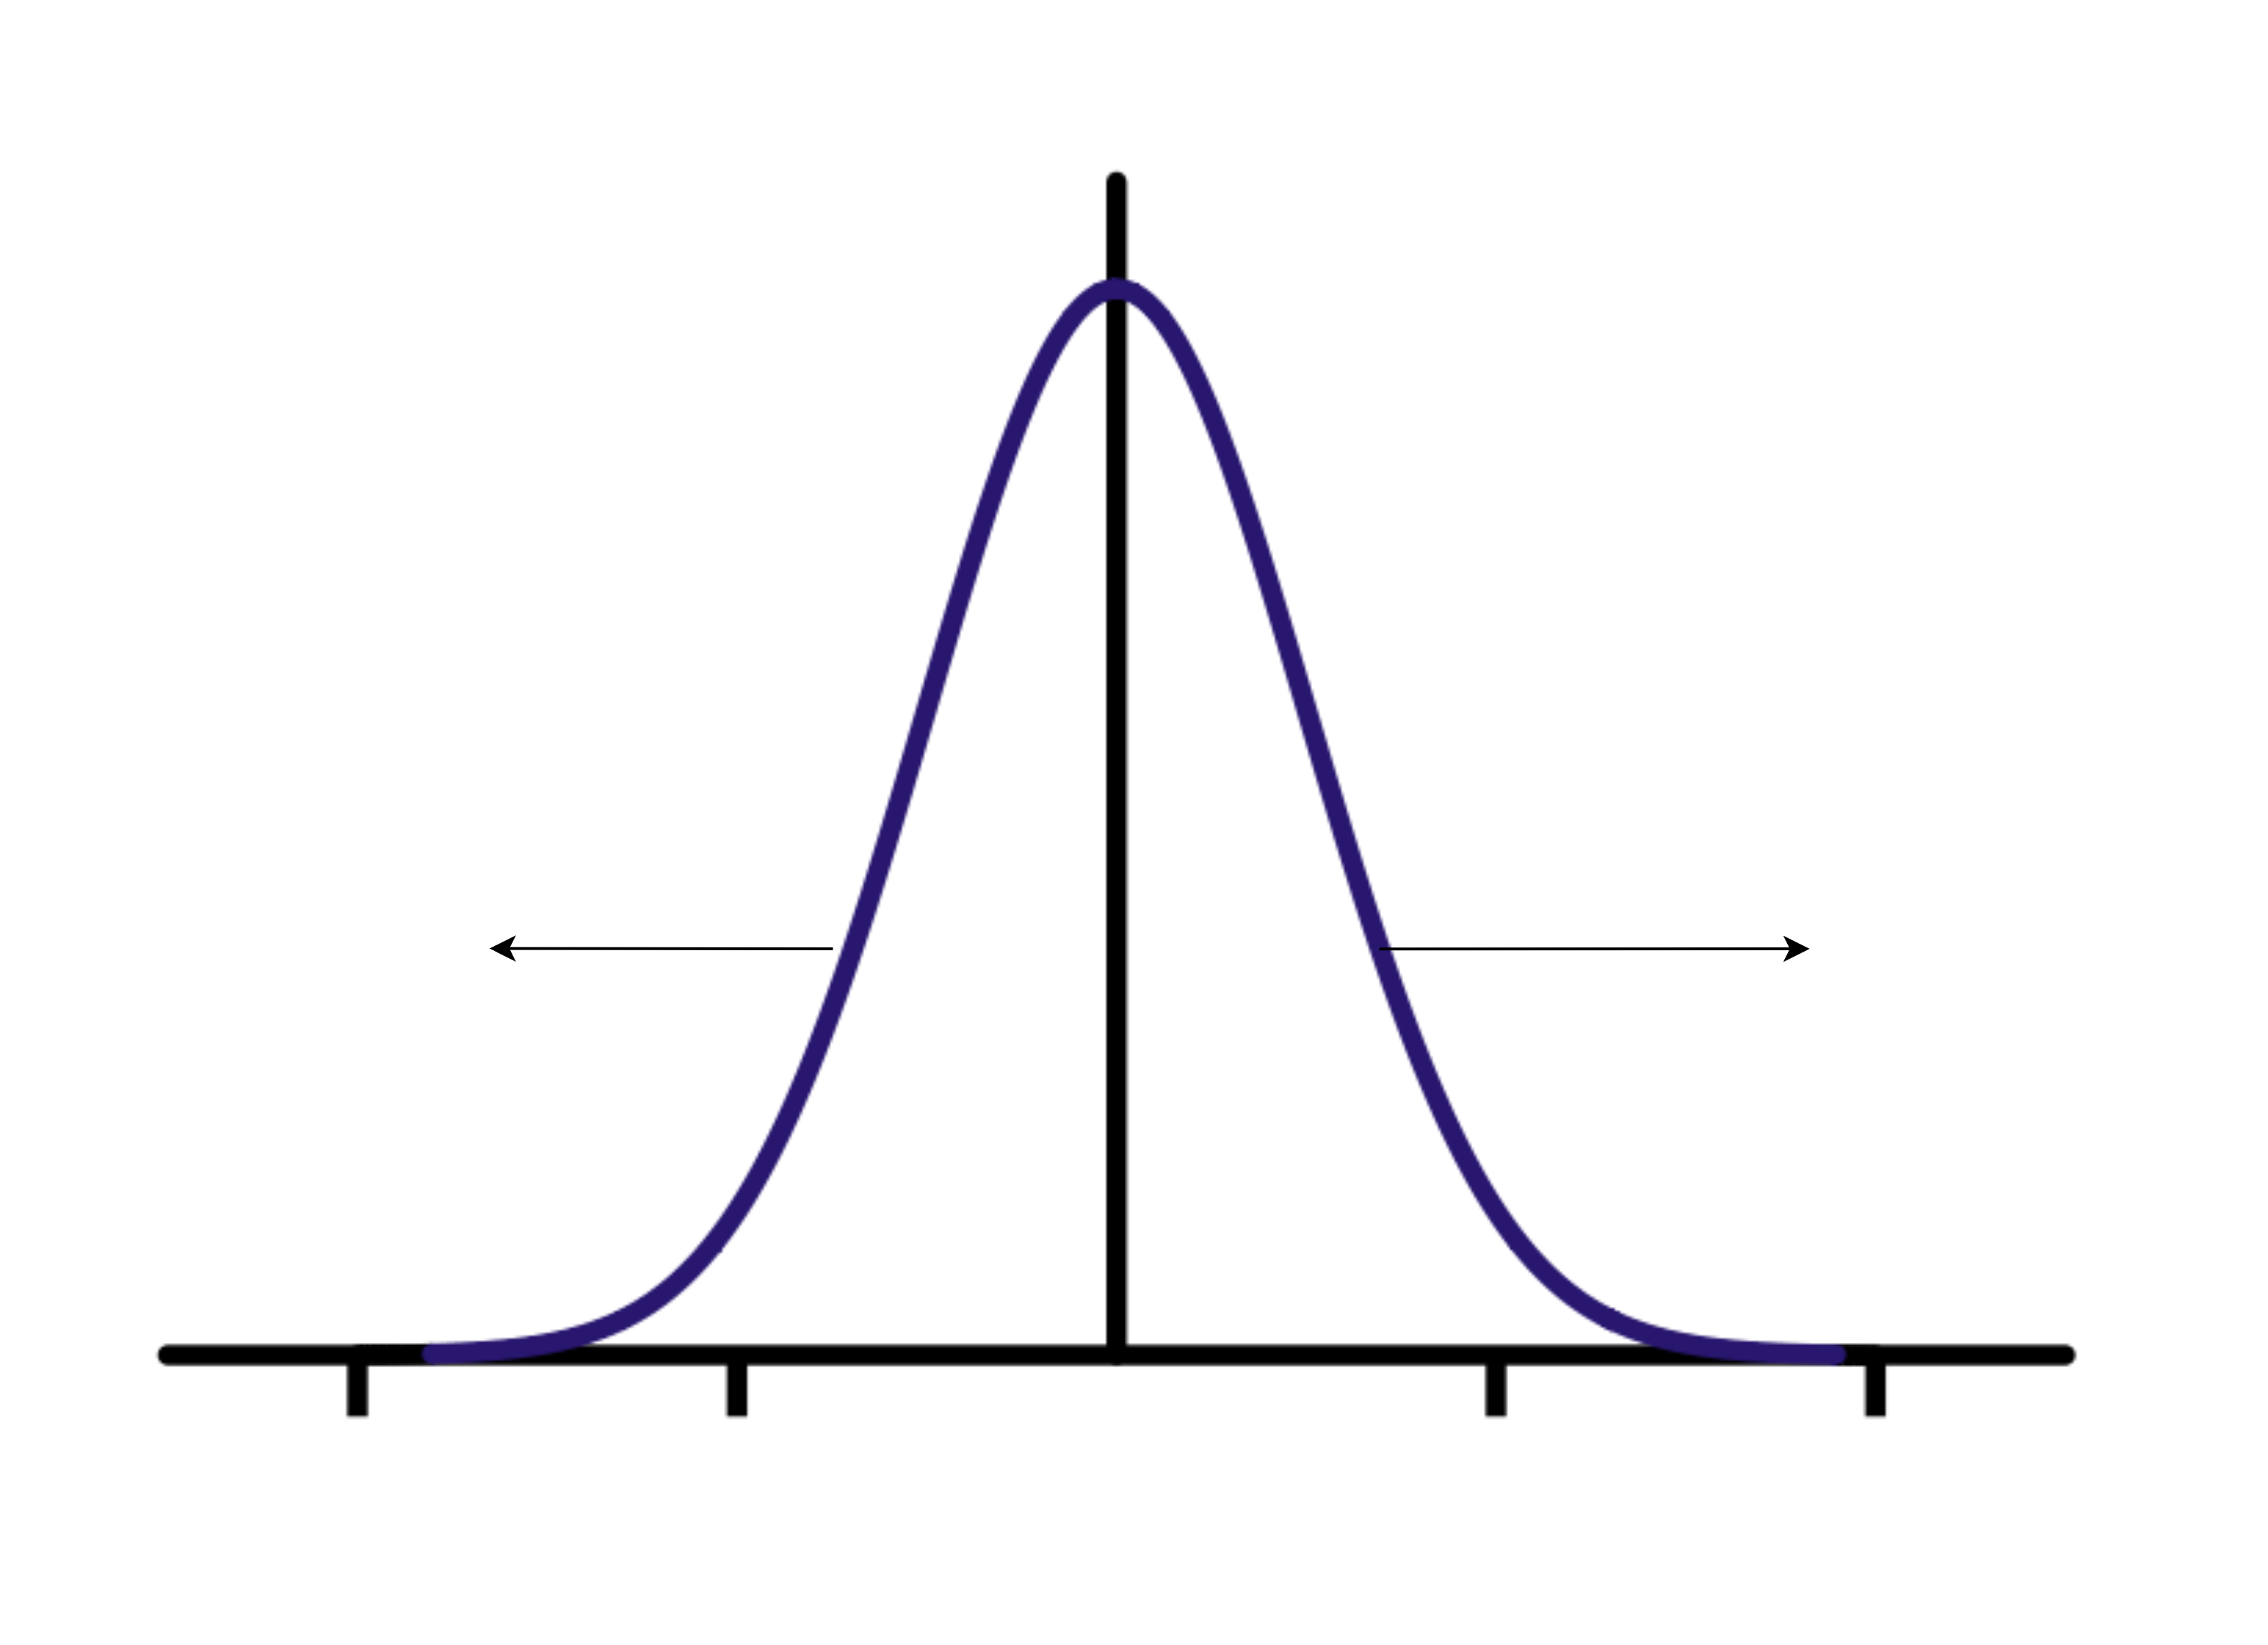

Similarly, if start manipulating the weights...

Inputs -> Mean: tensor(0.0022) Std: tensor(1.0055)
Outputs -> Mean: tensor(-0.2261) Std: tensor(221.1034)


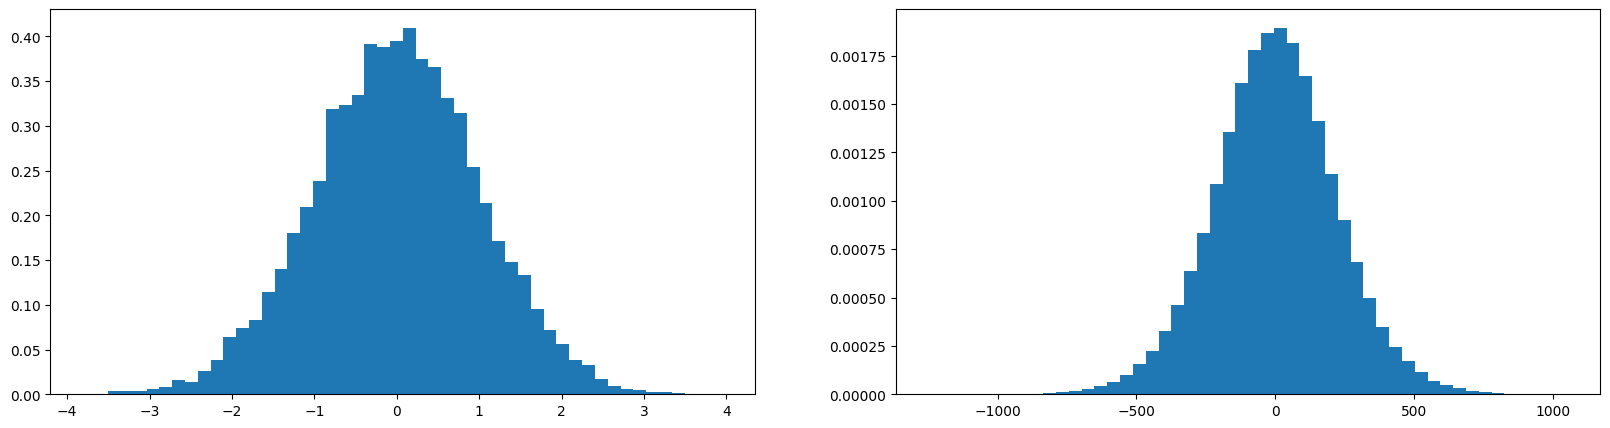

In [4]:
# This is just an example

inputs = torch.randn(1000, 10) # 1000 inputs of 10 dimensions drawn from a gaussian
# Weights also drawn from a gaussian and they look at 10 inputs and have 200 neurons within the layer
weights = torch.randn(10, 200) * 69

outputs = inputs @ weights

print("Inputs ->", "Mean:", inputs.mean(), "Std:", inputs.std())
print("Outputs ->", "Mean:", outputs.mean(), "Std:", outputs.std())

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(inputs.view(-1).tolist(), bins=50, density=True); # Visualizing inputs
plt.subplot(122)
plt.hist(outputs.view(-1).tolist(), bins=50, density=True); # Visualizing outputs

Multiplying it by a higher number it expands a lot...

Inputs -> Mean: tensor(-0.0242) Std: tensor(0.9986)
Outputs -> Mean: tensor(2.3762e-05) Std: tensor(0.0221)


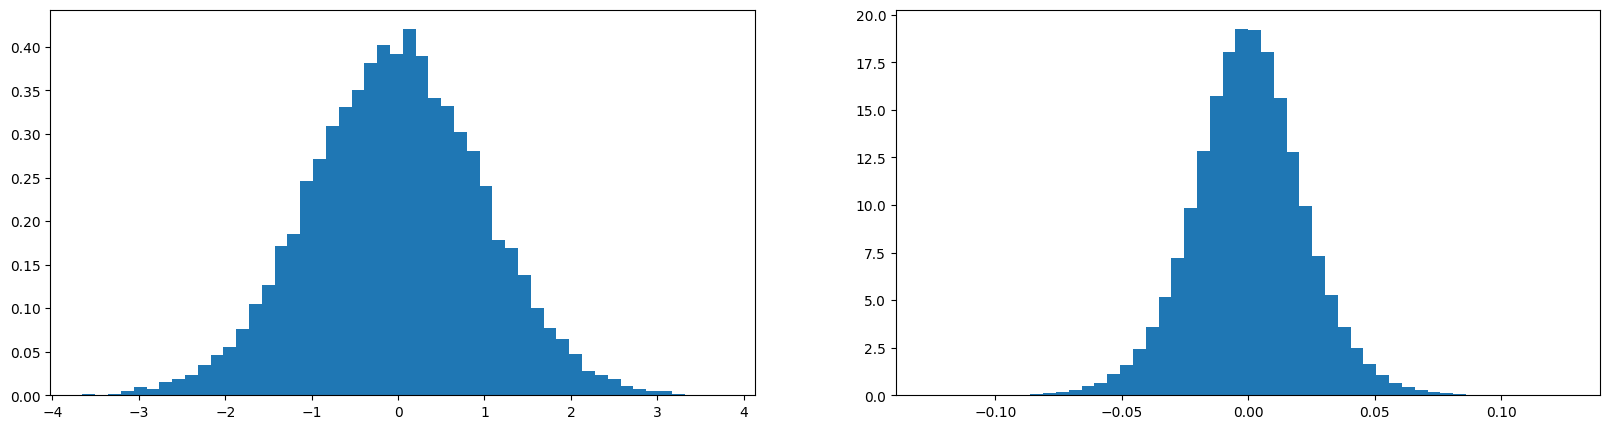

In [5]:
# This is just an example

inputs = torch.randn(1000, 10) # 1000 inputs of 10 dimensions drawn from a gaussian
# Weights also drawn from a gaussian and they look at 10 inputs and have 200 neurons within the layer
weights = torch.randn(10, 200) * 0.0069

outputs = inputs @ weights

print("Inputs ->", "Mean:", inputs.mean(), "Std:", inputs.std())
print("Outputs ->", "Mean:", outputs.mean(), "Std:", outputs.std())

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(inputs.view(-1).tolist(), bins=50, density=True); # Visualizing inputs
plt.subplot(122)
plt.hist(outputs.view(-1).tolist(), bins=50, density=True); # Visualizing outputs

Multiplying it by a lower number it shrinks a lot...

Now the question is....

**What do multiply the weights with, to preserve the exact standard deviation, which is 1?**

To answer this, it gives me the opportunity to invite you all to read another paper <a href="https://arxiv.org/abs/1502.01852">Delving Deep into Rectifiers</a> by <a href="https://kaiminghe.github.io/">Kaiming He et al</a> (2015). A number of papers have already looked into how we can initialize the neural networks, and this turns out to be pretty good. 

Keep in mind that in real life use case these neural networks can be very large and deep with non linearities in between and we want to make sure that these activations stay well behaved and they don't expand to infinity or shrink all the way to 0.

Once again, the paper is 11 pages long, but I will once again save you the time of reading it entirely and explaining the important parts we need from the paper.

In this paper they study convolutional neural networks and they study the ReLU and PReLU non linearities.

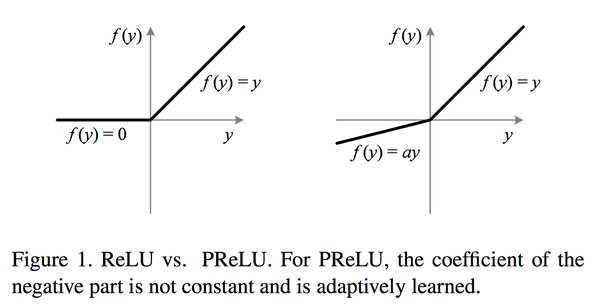

ReLU is a non-linearity that discards the negetive numbers and sets them to 0 and only the positive numbers pass through it.

And according to this paper they find that, because the ReLU is throwing away basically half of the distribution, they have to compensate for that with a **gain**.

So, when they initialize these weights they have to do it with a zero-mean Gaussian distribution whose standard deviation (std) is $\sqrt{2/\text{fan-in}}$

And because the ReLU throws away half the distribution, the factor 2 is there...

They not only study the behaviour the activations have in their neural network, they also study the backpropagation and they have to make sure that the gradients also are well behaved, so they have to end up updating the parameters, so what they find there is, if they initialize the forward pass properly, the backward pass also is approximately initialized upto a constant factor, but they also find that this is not a choice that matters too much.

This Kaiming initialization is also implemented in <a href="https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_">PyTorch</a>, which is to date the most common way of initializing the neural networks now.

This takes $\text{standard deviation}=\text{gain}/\sqrt{\text{fan-mode}}$

According to official PyTorch documentation:
```python
torch.nn.init.kaiming_normal_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu', generator=None)
```

Parameters
- tensor (Tensor) – an n-dimensional torch.Tensor
- a (float) – the negative slope of the rectifier used after this layer (only used with 'leaky_relu')
- mode (str) – either 'fan_in' (default) or 'fan_out'. Choosing 'fan_in' preserves the magnitude of the variance of the weights in the forward pass. Choosing 'fan_out' preserves the magnitudes in the backwards pass. (Because it doesn't matter too much most of us leave it as default)
- nonlinearity (str) – the non-linear function (nn.functional name) (We have to calculate the different gain based on the non-linearity).
- generator (Optional[Generator]) – the torch Generator to sample from (default: None)lt: None)

PyTorch also defines a `calculate_gain()` as:

| nonlinearity      | gain                                   |
|-------------------|----------------------------------------|
| Linear / Identity |                    1                   |
| Conv{1,2,3}D      |                    1                   |
| Sigmoid           |                    1                   |
| Tanh              |                  $5/3$                 |
| ReLU              |               $\sqrt{2}$               |
| Leaky Relu        | $\sqrt{2/(1+\text{negetive slope}^2)}$ |
| SELU              |                  $3/4$                 |

Now you might be asking, why do we need a gain?

In our case, we are using a *squashing* function `tanh()` which takes the tails of the inputs and tries to *squeeze* them within the range of -1 and 1.
So in order to fight the *squeeze* we need to boost the weights a little, so that we re-normalize everything back to unit standard deviation.

Now I will be skipping through this portion a little bit because, back in 2015 when this paper was published, everything was very fragile and everything needed to be set very carefully and properly.

But a number of currently modern innovations have made these settings unimportant and so, we don't have to initialize these neural networks exactly right.

Some of these modern innovations are:
1. Residual Connections
2. Normalization Layers (Batch Normalization, Layer Normalization, Group Normalization, and so on)
3. Optimizers (not only our own stocastic gradient descent, but also some of the complex ones such as RMSProp and Adam)

If you'd like to know how I usually initialize these neural networks, I usually go by the kaiming initialization.

To once again define kaiming initialization, we remember it as:
$$ \text{standard deviation}=\text{gain}/\sqrt{\text{fan mode}} $$
where, `fan-mode` is `fan-in` for our case

So if we take 10000 numbers from a gaussian and find its spread (standard-deviation):
```python
torch.randn(10000).std()
```
We get a result of about 1
```python
tensor(0.9950)
```
Now if we multiply these numbers with a value:
```python
(torch.randn(10000) * 0.2).std()
```
We see that the spread keeps taking on the value of the number that we multiply:
```python
tensor(0.2009)
```

Also as a note, because we are about to do square root of a number, we understand that $\sqrt{x}=x^{1/2}$.\
So we can simply do `x**0.5` to perform a square root of a value say `x`


According to our code then, we have the `tanh()` non linearities for which the gain is $(5/3)/\sqrt{\text{fan in}}$,\
And our `fan-in` is `(blockSize*embeddingFeatureSpaceLength)`,
So what we will have is $(5/3)/\sqrt{(\text{blockSize}*\text{embeddingFeatureSpaceLength})}$

Which evaluates to:
```python
weightsOfHiddenLayer = torch.randn((blockSize*embeddingFeatureSpaceLength), numberOfHiddenLayerNeurons, generator=generator) * (5/3) / ((blockSize*embeddingFeatureSpaceLength) ** 0.5)
```

So then we will be roughly in the same spot, running this initialization and we won't be taking any random magic numbers to initialize this neural network this time.

### Re-running the optimization with kaiming-initialization

In [9]:
# We will define a generator to give the same result on your machine, as of my machine
generator = torch.Generator().manual_seed(6942069420)
# Embedding Matrix (Input Layer)
embeddingFeatureSpaceLength = 10 
embeddingLookUpMatrix = torch.randn((vocabularySize, embeddingFeatureSpaceLength), generator=generator)
# Hidden Layer
numberOfHiddenLayerNeurons = 200 # We increase the number of neurons here
weightsOfHiddenLayer = torch.randn((blockSize*embeddingFeatureSpaceLength), numberOfHiddenLayerNeurons, generator=generator) * (5/3) / ((blockSize*embeddingFeatureSpaceLength) ** 0.5)
biasesOfHiddenLayer = torch.randn(numberOfHiddenLayerNeurons, generator=generator) * 0.01
# Output Layer / Final Layer
weightsOfFinalLayer = torch.randn(numberOfHiddenLayerNeurons, vocabularySize, generator=generator) * 0.01
biasesOfFinalLayer = torch.randn(vocabularySize, generator=generator) * 0
# Parameters
parameters = [embeddingLookUpMatrix, weightsOfHiddenLayer, biasesOfHiddenLayer, weightsOfFinalLayer, biasesOfFinalLayer]
# We set all the requires gradient to True
for parameter in parameters:
    parameter.requires_grad = True

In [10]:
# We want to track the losses that we use in the training
losses = []

# We define the number of epochs
epochs = 200000
for i in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=trainingInputs.shape[0], size=(32,)) # I changed it to 32 to make it look nicer in my mind
    inputBatch, outputBatch = trainingInputs[indexes], trainingOutputs[indexes]
    
    # Forward Pass (Mini-Batch)
    embedding = embeddingLookUpMatrix[inputBatch]
    concatenatedEmbedding = embedding.view(embedding.shape[0], -1) # These are all the input examples in a concatenated form
    hiddenLayerPreActivationStates = embedding.view(-1, blockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer
    hiddenLayerPostActivationStates = torch.tanh(hiddenLayerPreActivationStates) # We divided the states into two parts pre and post non-linearity
    logits = hiddenLayerPostActivationStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, trainingOutputs[indexes])
    
    # Backward Pass (Mini-Batch)
    for parameter in parameters:
        parameter.grad = None
    loss.backward()
    
    # Update Weights (Mini-Batch)
    learning_rate = 0.1 if i < 100000 else 0.01
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

    # Tracking the stats
    # We append the losses that we use per iteration
    if i % 10000 == 0: 
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item()) # We do that to squash the steep curve to a nicer graph

      0/ 200000: 3.2862
  10000/ 200000: 1.8812
  20000/ 200000: 2.1525
  30000/ 200000: 1.9374
  40000/ 200000: 1.8853
  50000/ 200000: 1.8819
  60000/ 200000: 2.0133
  70000/ 200000: 1.9198
  80000/ 200000: 2.3249
  90000/ 200000: 1.9311
 100000/ 200000: 1.5079
 110000/ 200000: 1.9191
 120000/ 200000: 1.8836
 130000/ 200000: 2.3134
 140000/ 200000: 1.7731
 150000/ 200000: 1.9781
 160000/ 200000: 1.7674
 170000/ 200000: 1.6827
 180000/ 200000: 2.1761
 190000/ 200000: 1.9662


In [11]:
# Method to split the 
@torch.no_grad() # Decorator for disabling gradient tracking throughout the function underneath
def splitLoss(split):
    input, output = {
        'Training': (trainingInputs, trainingOutputs),
        'Validation': (validationInputs, validationOutputs),
        'Testing': (testInputs, testOutputs)
    }[split]
    # Based on the split we can then index into the embedding look-up matrix using its inputs to get the embeddings
    embedding = embeddingLookUpMatrix[input]
    concatenatedEmbedding = embedding.view(embedding.shape[0], -1) # These are all the input examples in a concatenated form
    hiddenLayerStates = torch.tanh(concatenatedEmbedding @ weightsOfHiddenLayer + biasesOfHiddenLayer)
    logits = hiddenLayerStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, output)
    print(f"{split} Loss:{loss.item()}")  

# We can then call this method to calculate and print loss
splitLoss('Training')
splitLoss('Validation')

Training Loss:1.8906415700912476
Validation Loss:1.917124629020691


#### Loss Logs

Original loss:
```python
Training Loss:2.009695161819458
Validation Loss:2.0099663919448853
```

After fixing confident `softmax()` activations:
```python
Training Loss:1.945695161819458
Validation Loss:1.9705663919448853
``````

After fixing hidden `tanh()` activations:
```python
Training Loss:1.9219505786895752
Validation Loss:1.9380011558532715853
```

After using kaiming-initialization:
```python
Training Loss:1.8906415700912476
Validation Loss:1.917124629020691
```

Now, I talked how we don't have to exactly initialize these neural networks exactly and precisely and now I will introduce one of these modern innovations and that is **Batch Normalization**

# Batch Normalization

Batch Normalization came out back in 2015 by a team at <a href="www.google.com">Google</a> after publishing this <a href="https://arxiv.org/abs/1502.03167">paper</a>.\
It was an extremely impactful paper because it made it possible to train very deep neural networks quite reliably, and it did very strange things internally and basically just simply worked.

Before I explain batch normalization, this time, let's understand what we want first...

We want our `hiddenLayerPreActivationStates` to not take on very small because then the activation function won't trigger, and we also don't want them to be very large otherwise the tanh() will get saturated. Rather we want our `hiddenLayerPreActivationStates` to be roughly gaussian, or in other words, 0 mean and or either unit standard deviation or standard deviation to be 1 (at least at initialization).

Here's when batch normalization comes in. It says "okay bro, you have these hidden states, and you'd like them to be roughly gaussian... so why don't you just take the hidden states and normalize them to be gaussian?"...
And the reality check this paper did to the machine learning engineers like us was crazy... That is because these unit gaussians were perfectly differnetiable operations...

Once again,\
For those who like a concrete explaination of **Batch Normalization** to understand it's meaning, I've got you covered too bro...

**What is Batch Normalization?**

**Batch normalization** (also known as **batch norm**) is a method used to make training of artificial neural networks faster and more stable through normalization of the layers' inputs by re-centering and re-scaling.\
![NeedForBatchNorm](https://miro.medium.com/v2/resize:fit:720/format:webp/0*7x11OwxQZBlOQp8l.png)\
If we are able to somehow normalize the activations from each previous layer then the gradient descent will converge better during training.

How does it work?
In a neural network, batch normalization is achieved through a normalization step that fixes the means and variances of each layer's inputs.

According to the original paper they say,\
**Input:** Values of over a mini-batch: $\mathcal{B}=\{x_{1...m}\}$ \
*Parameters to be learned:* $\gamma$, $B$ \
**Output:** $\{y_{i}=BN_{\gamma,\beta}(x_{i})\}$ \
Mini-Batch Mean:
$$\mu_{B}\leftarrow\frac{1}{m}\sum_{i=1}^{m}x_{i}$$
Mini-Batch Variance:
$$\sigma_{\mathcal{B}}^{2}\leftarrow\frac{1}{m}\sum_{i=1}^{m}(x_{i}-\mu_{\mathcal{B}})^{2}$$
Normalize:
$$\hat{x_{i}}\leftarrow\frac{x_{i}-\mu_{\mathcal{B}}}{\sqrt{\sigma_{\mathcal{B}}^{2}+\epsilon}}$$
Scale and shift:
$$y_{i}\leftarrow\gamma\hat{x}_{i}+\beta\equiv BN_{\gamma,\beta}(x_{i})$$

$\epsilon$ is added in the denominator for numerical stability and is an arbitrarily small constant. (Basically prevent division by 0)

Let's come back to our code now...\
Once again, we want our `hiddenLayerPreActivationStates` to be roughly gaussian, or in other words, 0 mean and or either unit standard deviation or standard deviation to be 1 (at least at initialization).

We know that the shape of our `hiddenLayerPreActivationStates` is roughly (32, 200), in other words, 32 inputs and 200 neurons.\
So we can now easily calculate the mean and standard deviation of these states as:
```python
hiddenLayerPreActivationStates.mean(0, keepdim=True) # We calculate mean accross the 0th dimension and set keepdim to True to make it broadcastable
hiddenLayerPreActivationStates.std(0, keepdim=True)
```

The shapes of this mean and standard deviation then would be (1, 200).

Once, again to revise...\
$\text{standard deviation} = \sqrt{\text{variance}}$ or $\text{variance} = \text{standard deviation}^2$

So in order to normalize these `hiddenLayerPreActivationStates` we would need to follow the above formula:
$$\hat{x_{i}}\leftarrow\frac{x_{i}-\mu_{\mathcal{B}}}{\sqrt{\sigma_{\mathcal{B}}^{2}+\epsilon}}$$

**Where we take the mean of the states of each neuron and subtract it from each state and divide it by the standard deviation of those values of each neuron...**

OR

We will do:
```python
hiddenLayerPreActivationStates = embedding.view(-1, blockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer
hiddenLayerPreActivationStates = (hiddenLayerPreActivationStates - hiddenLayerPreActivationStates.mean(0, keepdim=True)) / hiddenLayerPreActivationStates.std(0, keepdim=True)
hiddenLayerPostActivationStates = torch.tanh(hiddenLayerPreActivationStates)
```

Seems good right?\
Everything is now perfectly differentiable and we seem to be in a good place to train the neural network\
Well it isn't...

The problem is you won't be able to achieve a very good result with this, that's because, we want these states to be roughly gaussian but only at initialization, and we don't want them to be forced to be gaussian everytime.\
We would rather want the neural network to move this around, and make it either diffuse or sharp, and make the activations to be either trigger happy or less trigger happy..\
In other words, we want this distribution to move around and rather want the back propagation to tell us how the distribution should move around...

So in addition to standardizing the distribution we have to introduce ourselves with the idea of *scale and shift*

$$y_{i}\leftarrow\gamma\hat{x}_{i}+\beta\equiv BN_{\gamma,\beta}(x_{i})$$
Here, $\gamma$ is the gain that scales the inputs and $\beta$ is another bias off-setter.

So we will do
```python
hiddenLayerPreActivationStates = batchGains * (hiddenLayerPreActivationStates - hiddenLayerPreActivationStates.mean(0, keepdim=True)) / hiddenLayerPreActivationStates.std(0, keepdim=True) + batchBiases
```

Keep this illustration in mind and we will go through it in a bit...
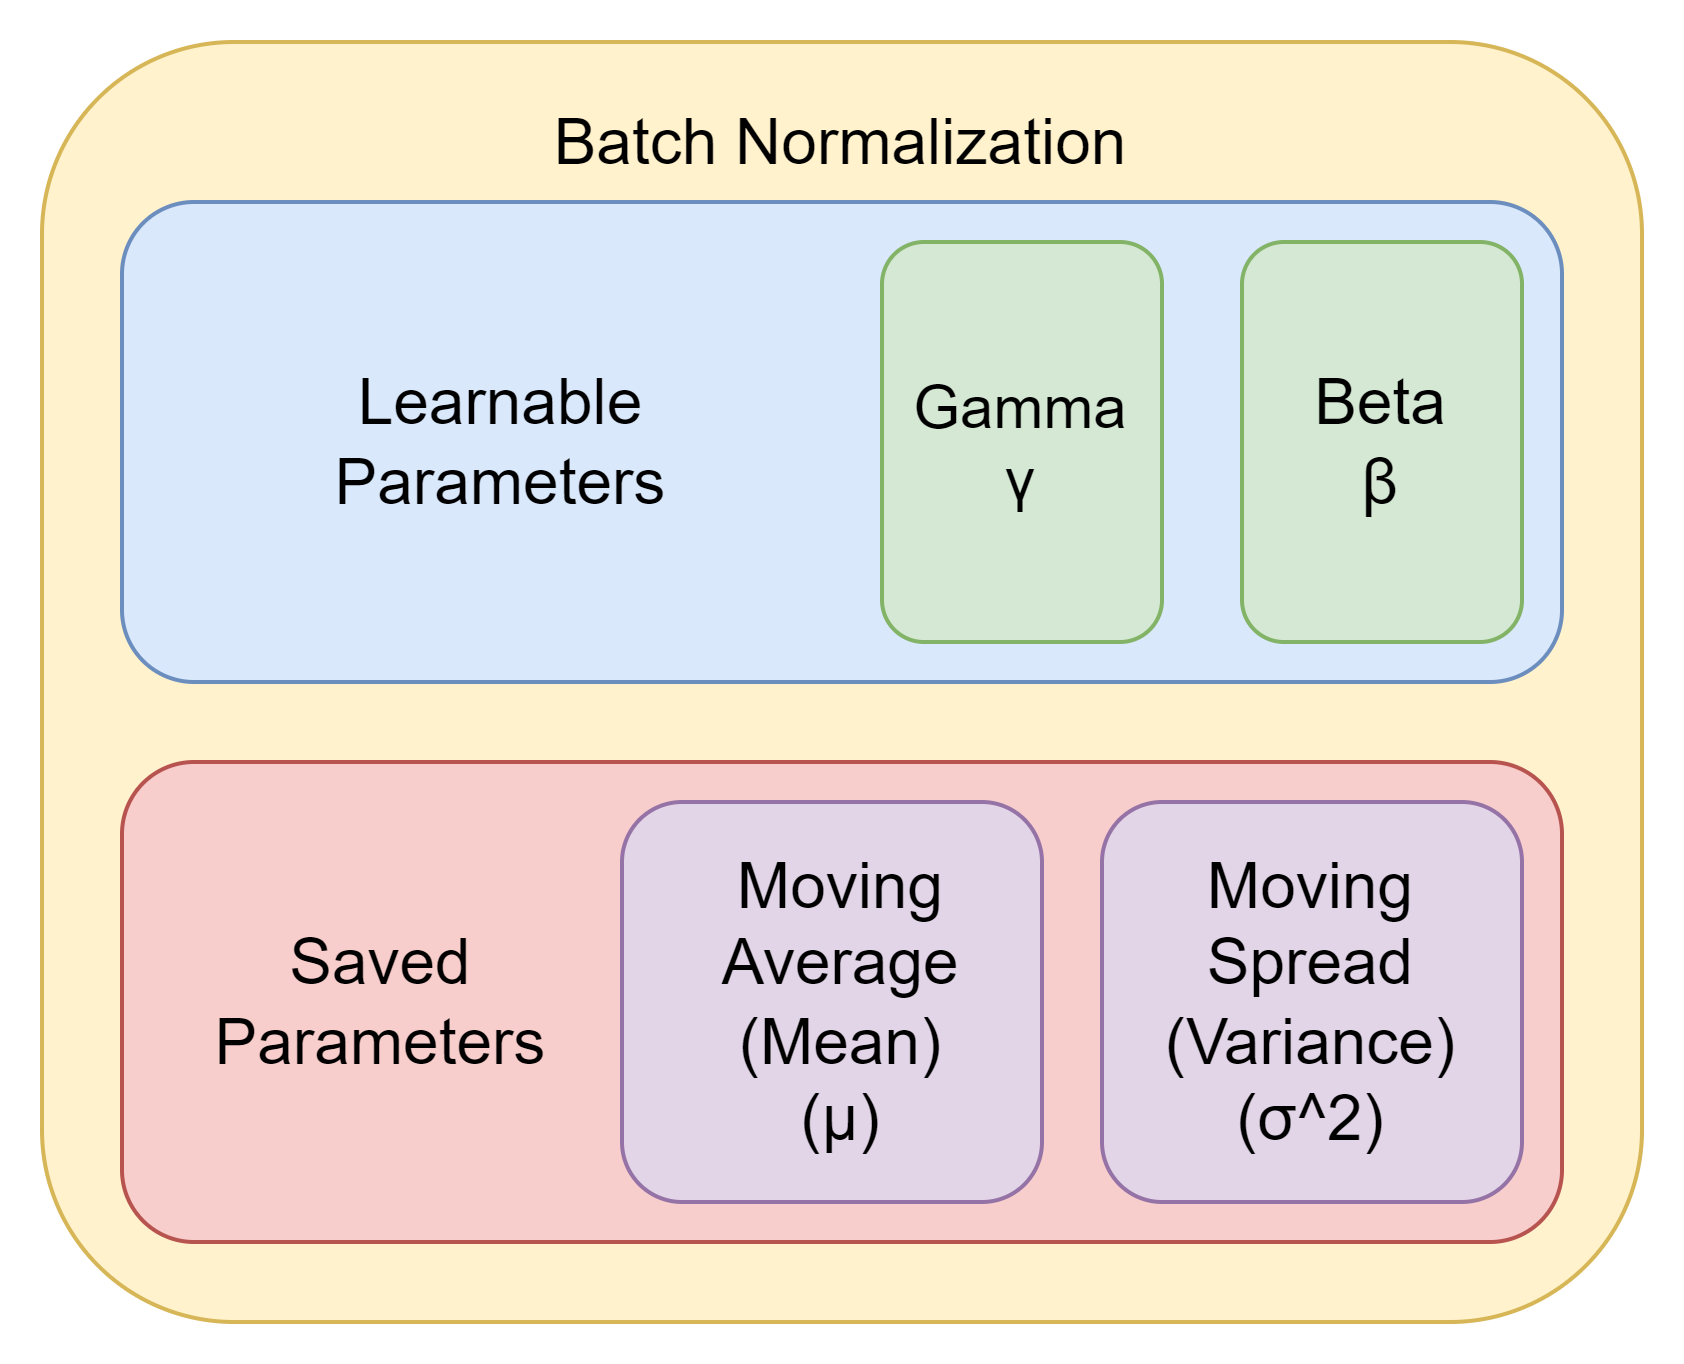

### Reinitializing the neural network with batch gains and batch biases and running optimization

In [8]:
# We will define a generator to give the same result on your machine, as of my machine
generator = torch.Generator().manual_seed(6942069420)
# Embedding Matrix (Input Layer)
embeddingFeatureSpaceLength = 10 
embeddingLookUpMatrix = torch.randn((vocabularySize, embeddingFeatureSpaceLength), generator=generator)
# Hidden Layer
numberOfHiddenLayerNeurons = 200 # We increase the number of neurons here
weightsOfHiddenLayer = torch.randn((blockSize*embeddingFeatureSpaceLength), numberOfHiddenLayerNeurons, generator=generator) * (5/3) / ((blockSize*embeddingFeatureSpaceLength) ** 0.5)
biasesOfHiddenLayer = torch.randn(numberOfHiddenLayerNeurons, generator=generator) * 0.01
# We do this to keep the firing value of each neuron to exactly unit gaussian at initialization
batchGains = torch.ones(1, numberOfHiddenLayerNeurons)
batchBiases = torch.zeros(1, numberOfHiddenLayerNeurons)

# Output Layer / Final Layer
weightsOfFinalLayer = torch.randn(numberOfHiddenLayerNeurons, vocabularySize, generator=generator) * 0.01
biasesOfFinalLayer = torch.randn(vocabularySize, generator=generator) * 0
# Parameters (We add the batch gains and biases to do gradient calculations during training and also tell us how the distribution should move)
parameters = [embeddingLookUpMatrix, weightsOfHiddenLayer, biasesOfHiddenLayer, weightsOfFinalLayer, biasesOfFinalLayer, batchGains, batchBiases] 
# We set all the requires gradient to True
for parameter in parameters:
    parameter.requires_grad = True

In [9]:
# We want to track the losses that we use in the training
losses = []

# We define the number of epochs
epochs = 200000
for i in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=trainingInputs.shape[0], size=(32,)) # I changed it to 32 to make it look nicer in my mind
    inputBatch, outputBatch = trainingInputs[indexes], trainingOutputs[indexes]
    
    # Forward Pass (Mini-Batch)
    embedding = embeddingLookUpMatrix[inputBatch]
    concatenatedEmbedding = embedding.view(embedding.shape[0], -1) # These are all the input examples in a concatenated form
    hiddenLayerPreActivationStates = embedding.view(-1, blockSize*embeddingFeatureSpaceLength) @ weightsOfHiddenLayer + biasesOfHiddenLayer
    hiddenLayerPreActivationStates = batchGains * (hiddenLayerPreActivationStates - hiddenLayerPreActivationStates.mean(0, keepdim=True)) / hiddenLayerPreActivationStates.std(0, keepdim=True) + batchBiases
    hiddenLayerPostActivationStates = torch.tanh(hiddenLayerPreActivationStates) # We divided the states into two parts pre and post non-linearity
    logits = hiddenLayerPostActivationStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, trainingOutputs[indexes])
    
    # Backward Pass (Mini-Batch)
    for parameter in parameters:
        parameter.grad = None
    loss.backward()
    
    # Update Weights (Mini-Batch)
    learning_rate = 0.1 if i < 100000 else 0.01
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

    # Tracking the stats
    # We append the losses that we use per iteration
    if i % 10000 == 0: 
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item()) # We do that to squash the steep curve to a nicer graph

      0/ 200000: 3.2993
  10000/ 200000: 2.3646
  20000/ 200000: 2.2568
  30000/ 200000: 1.9007
  40000/ 200000: 2.0341
  50000/ 200000: 2.0195
  60000/ 200000: 1.7905
  70000/ 200000: 1.9591
  80000/ 200000: 2.3577
  90000/ 200000: 1.9832
 100000/ 200000: 1.8060
 110000/ 200000: 2.1512
 120000/ 200000: 2.0512
 130000/ 200000: 1.8943
 140000/ 200000: 1.6794
 150000/ 200000: 1.8634
 160000/ 200000: 1.8812
 170000/ 200000: 1.9778
 180000/ 200000: 1.7146
 190000/ 200000: 1.8464


In [10]:
# Method to split the 
@torch.no_grad() # Decorator for disabling gradient tracking throughout the function underneath
def splitLoss(split):
    input, output = {
        'Training': (trainingInputs, trainingOutputs),
        'Validation': (validationInputs, validationOutputs),
        'Testing': (testInputs, testOutputs)
    }[split]
    # Based on the split we can then index into the embedding look-up matrix using its inputs to get the embeddings
    embedding = embeddingLookUpMatrix[input]
    concatenatedEmbedding = embedding.view(embedding.shape[0], -1) # These are all the input examples in a concatenated form
    hiddenLayerPreActivationStates = concatenatedEmbedding @ weightsOfHiddenLayer + biasesOfHiddenLayer
    # We add this line to test these states as well
    hiddenLayerPreActivationStates = batchGains * (hiddenLayerPreActivationStates - hiddenLayerPreActivationStates.mean(0, keepdim=True)) / hiddenLayerPreActivationStates.std(0, keepdim=True) + batchBiases
    hiddenLayerPostActivationStates = torch.tanh(hiddenLayerPreActivationStates)
    logits = hiddenLayerPostActivationStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, output)
    print(f"{split} Loss:{loss.item()}")  

# We can then call this method to calculate and print loss
splitLoss('Training')
splitLoss('Validation')

Training Loss:1.906158447265625
Validation Loss:1.9263619184494019


#### Loss Logs

Original loss:
```python
Training Loss:2.009695161819458
Validation Loss:2.0099663919448853
```

After fixing confident `softmax()` activations:
```python
Training Loss:1.945695161819458
Validation Loss:1.9705663919448853
``````

After fixing hidden `tanh()` activations:
```python
Training Loss:1.9219505786895752
Validation Loss:1.9380011558532715853
```

After using kaiming-initialization:
```python
Training Loss:1.8906415700912476
Validation Loss:1.917124629020691
```

After using batch normalization layer:
```python
Training Loss:1.906158447265625
Validation Loss:1.9263619184494019
```

See how these losses are now comparable to the other losses now?

But I am not expecting a very good result with this, because we are dealing with a very simple neural network and has just one hidden layer.\
And because we already scaled the weights to have the roughly gaussian shape, the batch normalization is not doing much in this case.

But once we start having much deeper neural networks with lots of different types of operations, it will become very very difficult to tune the scales of these weight matrices such that all the activations throughout the neural network to be roughly gaussian...

But compared to this, it would be much much easier to sprinkle batch normalization layers throughout the neural network...

And it then becomes customary to add these batch normalization layers just after some of these linear layers and convolution layers (will cover in the future) which will control these activations at every point in those neural networks, also it does not require us to do perfect mathematics to care about these activation distributions for all the granular blocks that we might want to introduce to those neural networks, and it significantly stabilizes the training. Which thus, makes these layers quite popular...

But this magic comes at a terrible cost,\
So if we think about what's happening in these batch processings is, something quite terribly strange...\
Previously we had a single example feeding into a neural network and had to calculate the activations and logits, which was a deterministic process.\
Then, because of training efficiency we started using batches of examples, but those batches of examples were processed independently, which was simple an inefficiency thing.\
But now in batch normalization, because of the normalization through the batch, we started coupling these examples together during the forward pass and backward pass of the neural network.\
But now for `hiddenLayerPreActivationStates` and `logits` for any one example, they are not just a function of that example and its inputs, but they're also the examples of all the other examples that happen to come for a ride in that batch. And these examples are sampled randomly.\
So for each example `hiddenLayerPreActivationStates` are going to change a little bit, which will make it *jitter*, because the mean and standard deviations will be impacted.\
You might think of this as a bug, but in a very strange way, this actually turns out to be good in training of these neural networks.\
You can now think of it as a regularizer, which is essentially padding out any one of these input examples and is introducing a little bit of entropy and acts as a part of *data-augmentation*(will also cover in the future) which makes it harder for the neural network to overfit these examples.
So deceivingly, because this is a regularizer, it has made it harder to remove the use of batch normalization, because nobody likes that these examples are coupled mathematically which leads to a lot of bugs and other issues.

People have also tried to deprecate the use of batch normalization using other normalization techniques that **do not couple the examples of the batch**:
1. Layer Normalization
2. Instance Normalization
3. Group Normalization
and so on...

Here's one of the strange outcomes of batch normalization, where I came across when I was evaluating the loss on the validation set...

Basically when we are done with the training of our neural network, we would want to deploy it somewhere in some kind of a setting, and we would like to get a prediction from our neural network. But how do we do that when we in our forward pass calculate the mean and the standard deviation in batch, *which expects batches as an input* now? So how do we *feed in a single example and get sensible results out of the neural network*?

And the batch normalization paper proposes that we have to have a **step after training that sets the mean and standard deviation a single time over the training set.** 

Once again, we don't want the neural network to train while we calculate the mean and standard deviation for this step.

So now,

Previously we had:
```python
hiddenLayerPreActivationStates = batchGains * (hiddenLayerPreActivationStates - hiddenLayerPreActivationStates.mean(0, keepdim=True)) / hiddenLayerPreActivationStates.std(0, keepdim=True) + batchBiases
```

Now we would like to have a step after training:
```python
# Another way of not using gradients
with torch.no_grad():
    # Getting the embeddings for the training inputs by indexing into the embedding look-up matrix
    embedding = embeddingLookUpMatrix[trainingInputs]
    concatenatedEmbedding = embedding.view(embedding.shape[0], -1)
    hiddenLayerPreActivationStates = concatenatedEmbedding @ weightsOfHiddenLayer + biasesOfHiddenLayer
    # Storing the mean and standard deviation of the batch for a single time
    batchMean = hiddenLayerPreActivationStates.mean(0, keepdim=True)
    batchStandardDeviation = hiddenLayerPreActivationStates.std(0, keepdim=True)
```

So now, instead of calculating these batchMeans and batchStandardDeviations everytime, during test time we have:
```python
# Method to split the 
@torch.no_grad() # Decorator for disabling gradient tracking throughout the function underneath
def splitLoss(split):
    input, output = {
        'Training': (trainingInputs, trainingOutputs),
        'Validation': (validationInputs, validationOutputs),
        'Testing': (testInputs, testOutputs)
    }[split]
    # Based on the split we can then index into the embedding look-up matrix using its inputs to get the embeddings
    embedding = embeddingLookUpMatrix[input]
    concatenatedEmbedding = embedding.view(embedding.shape[0], -1) # These are all the input examples in a concatenated form
    hiddenLayerPreActivationStates = concatenatedEmbedding @ weightsOfHiddenLayer + biasesOfHiddenLayer
    # We add this line to test these states as well
    hiddenLayerPreActivationStates = batchGains * (hiddenLayerPreActivationStates - batchMean) / batchStandardDeviation + batchBiases
    hiddenLayerPostActivationStates = torch.tanh(hiddenLayerPreActivationStates)
    logits = hiddenLayerPostActivationStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, output)
    print(f"{split} Loss:{loss.item()}")  

# We can then call this method to calculate and print loss
splitLoss('Training')
splitLoss('Validation')
```

After we use these, we will see that we get a single example during inference even if the losses look similar for now.

Lazy... Lazy... LAZY...

Nobody likes to have a "second step" after neural network training...\
So batch normalization paper introduced one more idea, which is, we can estimate the mean and standard deviation in a running manner during the training itself of the neural network.

Let's see what that looks like now...

Remember, how in the beginning we had a mean of roughly 0 and a standard deviation of roughly 1?\
We will use that logic here now...

Keeping batch normalization paper now in mind,\
We want to initialize these *running means* and *running standard deviations* and during training or the forward pass of the neural network, we want to calculate the *running means* and *running standard deviations* without tracking the gradients, and calculating it with the notion of "mostly what it used to be" to a "very little of what is right now".


Enough with the word-play...\
Let's see how it changes our current code...

Let's first move our means and standard deviations for the forward pass first to make it simpler:
```python
# Forward Pass (Mini-Batch)
...
hiddenLayerPreActivationStates = concatenatedEmbedding @ weightsOfHiddenLayer + biasesOfHiddenLayer

# We move our means and standard deviation means into variables for simpler explanation
batchMeanAtIteration = hiddenLayerPreActivationStates.mean(0, keepdim=True)
batchStandardDeviationAtIteration = hiddenLayerPreActivationStates.std(0, keepdim=True)

hiddenLayerPreActivationStates = batchGains * (hiddenLayerPreActivationStates - batchMeanAtIteration) / batchStandardDeviationAtIteration + batchBiases
hiddenLayerPostActivationStates = torch.tanh(hiddenLayerPreActivationStates) 
...
```
So, just like I said *"We want to initialize these *running means* and *running standard deviations*"*, we can now initialize them:
```python
# We do this to keep the firing value of each neuron to exactly unit gaussian at initialization
batchGains = torch.ones(1, numberOfHiddenLayerNeurons)
batchBiases = torch.zeros(1, numberOfHiddenLayerNeurons)
# We initialize running means and running standard deviations
batchRunningMean = torch.zeros(1, numberOfHiddenLayerNeurons)
batchRunningStandardDeviation = torch.ones(1, numberOfHiddenLayerNeurons)
```
Why did I initialize them with 0 and 1?\
Remember how I said: "Remember, how in the beginning we had a mean of roughly 0 and a standard deviation of roughly 1?"\
That's exactly why.


Now we can update these initialized *running* items during forward pass without tracking the gradients:
```python
# Forward Pass (Mini-Batch)
...
with torch.no_grad():
    # Updating The Saved Means Smoothly
    batchRunningMean = 0.999 * batchRunningMean + 0.001 * batchMeanAtIteration
    batchRunningStandardDeviation = 0.999 * batchRunningStandardDeviation + 0.001 * batchStandardDeviationAtIteration
...
# Backward Pass (Mini-Batch)
```

Here `0.999` is the *"mostly what it used to be"* (previous) and `0.001` is the *"very little of what is right now"* (current).

This is also how the batch normalization layer is implemented in PyTorch.

Also, during test time, we will use these running means and speads:
```python
# Method to split the 
@torch.no_grad() # Decorator for disabling gradient tracking throughout the function underneath
def splitLoss(split):
    input, output = {
        'Training': (trainingInputs, trainingOutputs),
        'Validation': (validationInputs, validationOutputs),
        'Testing': (testInputs, testOutputs)
    }[split]
    # Based on the split we can then index into the embedding look-up matrix using its inputs to get the embeddings
    embedding = embeddingLookUpMatrix[input]
    concatenatedEmbedding = embedding.view(embedding.shape[0], -1) # These are all the input examples in a concatenated form
    hiddenLayerPreActivationStates = concatenatedEmbedding @ weightsOfHiddenLayer + biasesOfHiddenLayer
    # We add this line to test these states as well
    hiddenLayerPreActivationStates = batchGains * (hiddenLayerPreActivationStates - batchRunningMean) / batchRunningStandardDeviation + batchBiases
    hiddenLayerPostActivationStates = torch.tanh(hiddenLayerPreActivationStates)
    logits = hiddenLayerPostActivationStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, output)
    print(f"{split} Loss:{loss.item()}")  
```

This way, we **elemenate the need of explicit stage of caliberation, because we now do it in-line**.

So now, our code looks like...

In [7]:
# We will define a generator to give the same result on your machine, as of my machine
generator = torch.Generator().manual_seed(6942069420)
# Embedding Matrix (Input Layer)
embeddingFeatureSpaceLength = 10 
embeddingLookUpMatrix = torch.randn((vocabularySize, embeddingFeatureSpaceLength), generator=generator)
# Hidden Layer
numberOfHiddenLayerNeurons = 200 # We increase the number of neurons here
weightsOfHiddenLayer = torch.randn((blockSize*embeddingFeatureSpaceLength), numberOfHiddenLayerNeurons, generator=generator) * (5/3) / ((blockSize*embeddingFeatureSpaceLength) ** 0.5)
biasesOfHiddenLayer = torch.randn(numberOfHiddenLayerNeurons, generator=generator) * 0.01
# We do this to keep the firing value of each neuron to exactly unit gaussian at initialization
batchGains = torch.ones(1, numberOfHiddenLayerNeurons)
batchBiases = torch.zeros(1, numberOfHiddenLayerNeurons)
# We initialize running means and running standard deviations
batchRunningMean = torch.zeros(1, numberOfHiddenLayerNeurons)
batchRunningStandardDeviation = torch.ones(1, numberOfHiddenLayerNeurons)
# Output Layer / Final Layer
weightsOfFinalLayer = torch.randn(numberOfHiddenLayerNeurons, vocabularySize, generator=generator) * 0.01
biasesOfFinalLayer = torch.randn(vocabularySize, generator=generator) * 0
# Parameters (We add the batch gains and biases to do gradient calculations during training and also tell us how the distribution should move)
parameters = [embeddingLookUpMatrix, weightsOfHiddenLayer, biasesOfHiddenLayer, weightsOfFinalLayer, biasesOfFinalLayer, batchGains, batchBiases] 
# We set all the requires gradient to True
for parameter in parameters:
    parameter.requires_grad = True

In [8]:
# We want to track the losses that we use in the training
losses = []

# We define the number of epochs
epochs = 200000
for i in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=trainingInputs.shape[0], size=(32,)) # I changed it to 32 to make it look nicer in my mind
    inputBatch, outputBatch = trainingInputs[indexes], trainingOutputs[indexes]
    
    # Forward Pass (Mini-Batch)
    embedding = embeddingLookUpMatrix[inputBatch]
    concatenatedEmbedding = embedding.view(embedding.shape[0], -1) # These are all the input examples in a concatenated form
    hiddenLayerPreActivationStates = concatenatedEmbedding @ weightsOfHiddenLayer + biasesOfHiddenLayer
    # We move our means and standard deviation means into variables for simpler explanation
    batchMeanAtIteration = hiddenLayerPreActivationStates.mean(0, keepdim=True)
    batchStandardDeviationAtIteration = hiddenLayerPreActivationStates.std(0, keepdim=True)
    hiddenLayerPreActivationStates = batchGains * (hiddenLayerPreActivationStates - batchMeanAtIteration) / batchStandardDeviationAtIteration + batchBiases
    hiddenLayerPostActivationStates = torch.tanh(hiddenLayerPreActivationStates) # We divided the states into two parts pre and post non-linearity
    logits = hiddenLayerPostActivationStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, trainingOutputs[indexes])

    with torch.no_grad():
        # Updating The Saved Means And Spreads Smoothly
        batchRunningMean = 0.999 * batchRunningMean + 0.001 * batchMeanAtIteration
        batchRunningStandardDeviation = 0.999 * batchRunningStandardDeviation + 0.001 * batchStandardDeviationAtIteration
    
    # Backward Pass (Mini-Batch)
    for parameter in parameters:
        parameter.grad = None
    loss.backward()
    
    # Update Weights (Mini-Batch)
    learning_rate = 0.1 if i < 100000 else 0.01
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

    # Tracking the stats
    # We append the losses that we use per iteration
    if i % 10000 == 0: 
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item()) # We do that to squash the steep curve to a nicer graph

      0/ 200000: 3.2818
  10000/ 200000: 1.8935
  20000/ 200000: 2.3879
  30000/ 200000: 1.6260
  40000/ 200000: 1.9479
  50000/ 200000: 2.0612
  60000/ 200000: 1.7221
  70000/ 200000: 2.3165
  80000/ 200000: 2.0332
  90000/ 200000: 1.8678
 100000/ 200000: 2.2686
 110000/ 200000: 1.8576
 120000/ 200000: 1.7410
 130000/ 200000: 1.7889
 140000/ 200000: 1.8347
 150000/ 200000: 2.2799
 160000/ 200000: 1.6850
 170000/ 200000: 2.0537
 180000/ 200000: 2.2251
 190000/ 200000: 1.5964


In [11]:
# Decorator for disabling gradient tracking throughout the function underneath
@torch.no_grad()
def splitLoss(split):
    input, output = {
        'Training': (trainingInputs, trainingOutputs),
        'Validation': (validationInputs, validationOutputs),
        'Testing': (testInputs, testOutputs)
    }[split]
    # Based on the split we can then index into the embedding look-up matrix using its inputs to get the embeddings
    embedding = embeddingLookUpMatrix[input]
    concatenatedEmbedding = embedding.view(embedding.shape[0], -1) # These are all the input examples in a concatenated form
    hiddenLayerPreActivationStates = concatenatedEmbedding @ weightsOfHiddenLayer + biasesOfHiddenLayer
    # We add this line to test these states as well
    hiddenLayerPreActivationStates = batchGains * (hiddenLayerPreActivationStates - batchRunningMean) / batchRunningStandardDeviation + batchBiases
    hiddenLayerPostActivationStates = torch.tanh(hiddenLayerPreActivationStates)
    logits = hiddenLayerPostActivationStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, output)
    print(f"{split} Loss:{loss.item()}")
# We can then call this method to calculate and print loss
splitLoss('Training')
splitLoss('Validation')

Training Loss:1.9061354398727417
Validation Loss:1.926653265953064


Lastly, two things to discuss:
1. We are not considering epsilon for the time being
2. We are being wasteful

How are we being wasteful?

See how we have `biasesOfHiddenLayer` and then we `batchRunningMean` but also add `batchBiases`?
Turns out we are already subtracting these biases in the form of `batchRunningMean` from `biasesOfHiddenLayer` and adding another bias in the form of `batchBiases`,\
So we are being wasteful, in the sense that `biasesOfHiddenLayer` will just be useless now, they will never get any gradients, they will never learn, and will simply stay constant. It doesn't really impact otherwise, but just acts wasteful.

So that is something to be considerate of. (We can just remove the initialization of `biasesOfHiddenLayer` and remove (`+ biasesOfHiddenLayer`) from the code.

How are they similar?

The similarity lies in the fact that both contribute to the process of controlling and shaping the activations of the hidden layer. \
While `batchRunningMean` focuses on normalizing the pre-activation states across batches, `biasesOfHiddenLayer` provide direct control over the activation levels of the neurons in the hidden layer. \
They both influence the overall behavior of the hidden layer activations, albeit in different ways.\
But if we visualize and compare their individual values they are going to be almost exactly similar.

#### Loss Logs

Original loss:
```python
Training Loss:2.009695161819458
Validation Loss:2.0099663919448853
```

After fixing confident `softmax()` activations:
```python
Training Loss:1.945695161819458
Validation Loss:1.9705663919448853
``````

After fixing hidden `tanh()` activations:
```python
Training Loss:1.9219505786895752
Validation Loss:1.9380011558532715853
```

After using kaiming-initialization:
```python
Training Loss:1.8906415700912476
Validation Loss:1.917124629020691
```

After using batch normalization layer:
```python
Training Loss:1.906158447265625
Validation Loss:1.9263619184494019
```

After using batch normalization layer using running mean & running standard deviations:
```python
Training Loss:1.9061354398727417
Validation Loss:1.926653265953064
```

### Summarizing Batch Normalization

We are using batch normalization to control the statistics of the activations of the neural network.\
It is common to sprinkle batch normalization layers across the neural network.\
We usually **place them after layers that have multiplication** (for example: a linear layer or a convolution layer and so on..).\
Batch normalization internally has parameters for the **gain and the bias which are trained using batch propagation**, it also has two buffers, namely the **running mean and the running standard deviation** which no not train using back propagation.

The batch normalization receives the mean and standard deviation of the activations that are feeding into the batch normalization layer over that batch, which then centers the batch to be unit gaussian, which then offsetts and scales it by the learned gain and bias. On top of that it keeps track of the mean and standard deviation of the inputs and it also maintains the running mean and running standard deviation, which can later be used during inference so that you don't need to re-estimate the mean and standard deviation every time which additionally allows us to test individual examples at test time.

In [8]:
# We will define a generator to give the same result on your machine, as of my machine
generator = torch.Generator().manual_seed(6942069420)
# Embedding Matrix (Input Layer)
embeddingFeatureSpaceLength = 10 
embeddingLookUpMatrix = torch.randn((vocabularySize, embeddingFeatureSpaceLength), generator=generator)
# Hidden Layer
numberOfHiddenLayerNeurons = 200 # We increase the number of neurons here
weightsOfHiddenLayer = torch.randn((blockSize*embeddingFeatureSpaceLength), numberOfHiddenLayerNeurons, generator=generator) * (5/3) / ((blockSize*embeddingFeatureSpaceLength) ** 0.5)
# We do this to keep the firing value of each neuron to exactly unit gaussian at initialization
batchGains = torch.ones(1, numberOfHiddenLayerNeurons)
batchBiases = torch.zeros(1, numberOfHiddenLayerNeurons)
# We initialize running means and running standard deviations
batchRunningMean = torch.zeros(1, numberOfHiddenLayerNeurons)
batchRunningStandardDeviation = torch.ones(1, numberOfHiddenLayerNeurons)
# Output Layer / Final Layer
weightsOfFinalLayer = torch.randn(numberOfHiddenLayerNeurons, vocabularySize, generator=generator) * 0.01
biasesOfFinalLayer = torch.randn(vocabularySize, generator=generator) * 0
# Parameters (We add the batch gains and biases to do gradient calculations during training and also tell us how the distribution should move)
parameters = [embeddingLookUpMatrix, weightsOfHiddenLayer, weightsOfFinalLayer, biasesOfFinalLayer, batchGains, batchBiases] 
# We set all the requires gradient to True
for parameter in parameters:
    parameter.requires_grad = True

In [9]:
# We want to track the losses that we use in the training
losses = []

# We define the number of epochs
epochs = 200000
for i in range(epochs):
    # Mini-Batches
    indexes = torch.randint(low=0, high=trainingInputs.shape[0], size=(32,)) # I changed it to 32 to make it look nicer in my mind
    inputBatch, outputBatch = trainingInputs[indexes], trainingOutputs[indexes]
    
    # Forward Pass (Mini-Batch)
    embedding = embeddingLookUpMatrix[inputBatch]
    concatenatedEmbedding = embedding.view(embedding.shape[0], -1) # These are all the input examples in a concatenated form
    hiddenLayerPreActivationStates = concatenatedEmbedding @ weightsOfHiddenLayer
    # We move our means and standard deviation means into variables for simpler explanation
    batchMeanAtIteration = hiddenLayerPreActivationStates.mean(0, keepdim=True)
    batchStandardDeviationAtIteration = hiddenLayerPreActivationStates.std(0, keepdim=True)
    hiddenLayerPreActivationStates = batchGains * (hiddenLayerPreActivationStates - batchMeanAtIteration) / batchStandardDeviationAtIteration + batchBiases
    hiddenLayerPostActivationStates = torch.tanh(hiddenLayerPreActivationStates) # We divided the states into two parts pre and post non-linearity
    logits = hiddenLayerPostActivationStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, trainingOutputs[indexes])

    with torch.no_grad():
        # Updating The Saved Means And Spreads Smoothly
        batchRunningMean = 0.999 * batchRunningMean + 0.001 * batchMeanAtIteration
        batchRunningStandardDeviation = 0.999 * batchRunningStandardDeviation + 0.001 * batchStandardDeviationAtIteration
    
    # Backward Pass (Mini-Batch)
    for parameter in parameters:
        parameter.grad = None
    loss.backward()
    
    # Update Weights (Mini-Batch)
    learning_rate = 0.1 if i < 100000 else 0.01
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

    # Tracking the stats
    # We append the losses that we use per iteration
    if i % 10000 == 0: 
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item()) # We do that to squash the steep curve to a nicer graph

      0/ 200000: 3.3107
  10000/ 200000: 1.8270
  20000/ 200000: 1.8311
  30000/ 200000: 1.7631
  40000/ 200000: 2.1118
  50000/ 200000: 2.1996
  60000/ 200000: 1.8378
  70000/ 200000: 2.1437
  80000/ 200000: 2.0530
  90000/ 200000: 2.1280
 100000/ 200000: 2.1692
 110000/ 200000: 2.0524
 120000/ 200000: 1.8750
 130000/ 200000: 2.2627
 140000/ 200000: 1.6686
 150000/ 200000: 1.7225
 160000/ 200000: 1.7326
 170000/ 200000: 2.4750
 180000/ 200000: 2.0675
 190000/ 200000: 1.5623


In [10]:
# Decorator for disabling gradient tracking throughout the function underneath
@torch.no_grad()
def splitLoss(split):
    input, output = {
        'Training': (trainingInputs, trainingOutputs),
        'Validation': (validationInputs, validationOutputs),
        'Testing': (testInputs, testOutputs)
    }[split]
    # Based on the split we can then index into the embedding look-up matrix using its inputs to get the embeddings
    embedding = embeddingLookUpMatrix[input]
    concatenatedEmbedding = embedding.view(embedding.shape[0], -1) # These are all the input examples in a concatenated form
    hiddenLayerPreActivationStates = concatenatedEmbedding @ weightsOfHiddenLayer
    # We add this line to test these states as well
    hiddenLayerPreActivationStates = batchGains * (hiddenLayerPreActivationStates - batchRunningMean) / batchRunningStandardDeviation + batchBiases
    hiddenLayerPostActivationStates = torch.tanh(hiddenLayerPreActivationStates)
    logits = hiddenLayerPostActivationStates @ weightsOfFinalLayer + biasesOfFinalLayer
    loss = F.cross_entropy(logits, output)
    print(f"{split} Loss:{loss.item()}")
# We can then call this method to calculate and print loss
splitLoss('Training')
splitLoss('Validation')

Training Loss:1.9066236019134521
Validation Loss:1.9303710460662842


#### Loss Logs

Original loss:
```python
Training Loss:2.009695161819458
Validation Loss:2.0099663919448853
```

After fixing confident `softmax()` activations:
```python
Training Loss:1.945695161819458
Validation Loss:1.9705663919448853
``````

After fixing hidden `tanh()` activations:
```python
Training Loss:1.9219505786895752
Validation Loss:1.9380011558532715853
```

After using kaiming-initialization:
```python
Training Loss:1.8906415700912476
Validation Loss:1.917124629020691
```

After using batch normalization layer:
```python
Training Loss:1.906158447265625
Validation Loss:1.9263619184494019
```

After using batch normalization layer using running mean & running standard deviations:
```python
Training Loss:1.9061354398727417
Validation Loss:1.926653265953064
```

After removing wasteful memory :
```python
Training Loss:1.9066236019134521
Validation Loss:1.9303710460662842
```

# Real Life Example: 1 (Residual Neural Network) or (ResNet)

**Note: We are not covering Residual Neural Networks right now, but we are trying to understand batch normalization through real life examples and their structures...**

So, what is a ResNet?

Let's visualize it first. (This is in context of an image classification neural network)

![ResNetStructureExample](https://i.stack.imgur.com/pkPi3.png)

We see that the image here feeds into the neural network, on the top. There seems to be many layers of repeating structure, all the way to predictions of what's inside that image. This repeating structure is made up of these blocks which are sequentially stacked up in this deep neural network.
We will discuss the code of this network next... (Don't run away, we will just relate what we did, and how similar our code is to their structure)...

This is the official ResNet code of PyTorch. <a href="https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py"> Access Here </a>

I'll save you a click as well...
![PyTorchResNetSnippet](ExplanationMedia/Images/resnetpytorch.png)

We see that there is a block called `Bottleneck`, which seems to be stacked up sequentially...\
We see there is an `__init__()` method... That method is similar to our initialization of weights and biases block.\
We also see there is a `forward()` method, that tells the neural network should act when it gets the inputs... Which is similar to our forward pass within the loop.

We see `conv1` input layers, which are `convolution layers`, and these layers are used for images.\
Convolution layers are same as a linear layer but they have spatial structure and the linear multiplication and bias offset are done on overlapping patches instead of the full input.\
We also see `BatchNorm2d` layers, which are none other than 2-dimensional batch normalization layers.\
And we also see `relu` non linearity layers, but in our case we are using the `tanh()` non linearity. (for very deep networks, ReLU works a little bit better).


We see a pattern in this code as well:
```python
out = self.convl(x)
out = self.bnl(out)
out = self.relu(out)

out = self.conv2(out)
out = self.bn2(out)
out = self.relu(out)
```

And basically we have the exact same pattern as well:
```python
# Linear Layer
hiddenLayerPreActivationStates = concatenatedEmbedding @ weightsOfHiddenLayer
# Batch Normalization Layer
batchMeanAtIteration = hiddenLayerPreActivationStates.mean(0, keepdim=True)
batchStandardDeviationAtIteration = hiddenLayerPreActivationStates.std(0, keepdim=True)
hiddenLayerPreActivationStates = batchGains * (hiddenLayerPreActivationStates - batchMeanAtIteration) / batchStandardDeviationAtIteration + batchBiases
# Non Linearity (Tanh())
hiddenLayerPostActivationStates = torch.tanh(hiddenLayerPreActivationStates)
```

I'd like to point out one more thing that is, we see this `conv1x1`, and when we look into it's definition:
```python
def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)
```

You see how bias is set to `False` by default?

This `bias` is set to `False` for the exact same reason why bias is not getting used in our case.

Now I'd like us to descend into these definitions of these PyTorch Layers and the parameters they take...\
But instead of a convolution layer we'd look at a <a href="https://pytorch.org/docs/stable/generated/torch.nn.Linear.html">Linear Layer</a>, because that's the layer we are using in our code.

## Linear
`CLASS`  `torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)`\
Applies a linear transformation to the incoming data: $y = xA^T+b$.

**Parameters:**
- **in_features** (int) – size of each input sample
- **out_features** (int) – size of each output sample
- **bias** (bool) – If set to `False`, the layer will not learn an additive bias. Default: `True`

**Shape:** \
&emsp;*Input*: (`∗`, $H_{in}$) where `∗` means any number of dimensions including none and $H_{in}$=in_features.\
&emsp;*Output*: (`∗`, $H_{out}$) where all but the last dimension are the same shape as the input and $H_{out}$=out_features.

**Variables:**
- **weight** (torch.Tensor) – the learnable weights of the module of shape `(out_features, in_features)`. The values are initialized from $u(-\sqrt{k}, \sqrt{k})$, where $k = 1/\text{in\_features}$
- **bias** – the learnable bias of the module of shape `(out_features)`. If `bias` is `True` the values are initialized from $u(-\sqrt{k}, \sqrt{k})$, where $k = 1/\text{in\_features}$


We have the transformation $y = wx+b$ but here they call it $y = xA^T+b$.

It does the same thing, whatever we did here:
```python
hiddenLayerPreActivationStates = concatenatedEmbedding @ weightsOfHiddenLayer
```

And in order to initialize this we need the `fan-in` and the `fan-out` to understand how big the weights matrix should be and whether or not you want a `bias`.\
In terms of the initialization of this layer, the variables that this layer uses are the `weights` and `bias`, just like we did in our case. And they also talk about how they initialize it by default, which is by doing a $1/\text{fan\_in}$ and doing its square root, and instead of a normal distribution, they do a uniform distribution.\
Its very much the same thing, and instead of `5/3` they are doing `1` which indicates that there is no gain that is being calculated. But otherwise it's basically the same thing $1/\sqrt{fan\_{in}}$ which is the scale of the weights, but drawn from a uniform distribution.

Let's look at the batch normalization layer as well...

## BATCHNORM1D
`CLASS`  `torch.nn.BatchNorm1d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None)`\
Applies Batch Normalization over a 2D or 3D input as described in the paper <a href="https://arxiv.org/abs/1502.03167">Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift</a> .

$$
y = \frac{x - \mathrm{E}[x]}{\sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta
$$

The mean and standard-deviation are calculated per-dimension over the mini-batches and $\gamma \text{and} \beta$ are learnable parameter vectors of size $C$(where $C$ is the number of features or channels of the input)


**Parameters:**
- **num_features** (int) – number of features or channels $C$ of the input
- **eps** (float) – a value added to the denominator for numerical stability. Default: `1e-5`
- **momentum** (float) – the value used for the running_mean and running_var computation. Can be set to None for cumulative moving average (i.e. simple average). Default: `0.1`
- **affine** (bool) – a boolean value that when set to `True`, this module has learnable affine parameters. Default: `True`
- **track_running_stats** (bool) – a boolean value that when set to `True`, this module tracks the running mean and variance, and when set to False, this module does not track such statistics, and initializes statistics buffers `running_mean` and `running_var` as `None`. When these buffers are `None`, this module always uses batch statistics. in both training and eval modes. Default: `True`

**Shape:**
- **Input**: `(N,C)` or `(N,C,L)`, where `N` is the batch size, `C` is the number of features or channels, and `L` is the sequence length
- **Output**: `(N,C)` or `(N,C,L)` (same shape as input)